In [1]:
import nbformat
nbformat.__version__

'5.0.3'

# description of data :
http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption


# column collection : 
# --------------------------------------------------------------------------------------
# 1.  date                                            
# 2.  time            
# 3.  global_active_power                
# 4.  global_reactive_power  
# 5.  voltage                                       
# 6.  global_intensity
# 7.  sub_metering_1                        
# 8.  sub_metering_2  
# 9.  sub_metering_3
# <h1></h1>


In [2]:
import sys, os, keras, itertools, warnings, math 

from statsmodels.tsa.api import VAR

from scipy.stats import randint
from scipy import stats
from scipy import stats
from scipy.stats import norm, randint 

from time import time

import seaborn as sns  
import numpy as np
from numpy import nan, isnan
import pandas as pd
from pandas import datetime as dt

import matplotlib.pyplot as plt  
from matplotlib import pyplot
import matplotlib.ticker as tkr
from mpl_toolkits.mplot3d import Axes3D 

from sklearn.linear_model import LinearRegression, Lasso 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline build
from sklearn import preprocessing, metrics 
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error 

# from keras.layers import Dense, LSTM, Dropout
from keras.layers import *
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers.convolutional import Conv1D, MaxPooling1D

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.4f' % x)
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
pd.plotting.register_matplotlib_converters()

Using TensorFlow backend.
C:\Users\Home\anaconda3\envs\tensorflow\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\Home\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  app.launch_new_instance()


In [3]:
df = pd.read_csv('household_power_consumption.txt', sep=';', nrows=82000, 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')


In [4]:
print("row count of df = ", len(df))

row count of df =  82000


In [5]:
df.head() 

Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00               4.2160                 0.4180 234.8400   
2006-12-16 17:25:00               5.3600                 0.4360 233.6300   
2006-12-16 17:26:00               5.3740                 0.4980 233.2900   
2006-12-16 17:27:00               5.3880                 0.5020 233.7400   
2006-12-16 17:28:00               3.6660                 0.5280 235.6800   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00           18.4000          0.0000          1.0000   
2006-12-16 17:25:00           23.0000          0.0000          1.0000   
2006-12-16 17:26:00           23.0000          0.0000          2.0000   
2006-12-16 17:27:00           23.0000          0.0000          1.0000   
2006-12-16 17:28:00           15.8000          0.0000          1.0000   

                     Sub_metering_3  
dt                                   
2006-12-16 17:24:00         17.0000  
2006-12-16 17:25:00         16.0000  
2006-12-16 17:26:00         17.0000  
2006-12-16 17:27:00         17.0000  
2006-12-16 17:28:00         17.0000

In [6]:
df.tail()

Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2007-02-11 15:59:00               0.3540                 0.0820 241.6600   
2007-02-11 16:00:00               0.3660                 0.1140 241.5500   
2007-02-11 16:01:00               0.3520                 0.0920 240.4500   
2007-02-11 16:02:00               0.3540                 0.0860 241.5600   
2007-02-11 16:03:00               0.3340                 0.0800 241.7400   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2007-02-11 15:59:00            1.6000          0.0000          0.0000   
2007-02-11 16:00:00            1.6000          0.0000          0.0000   
2007-02-11 16:01:00            1.6000          0.0000          0.0000   
2007-02-11 16:02:00            1.6000          0.0000          0.0000   
2007-02-11 16:03:00            1.4000          0.0000          1.0000   

                     Sub_metering_3  
dt                                   
2007-02-11 15:59:00          0.0000  
2007-02-11 16:00:00          0.0000  
2007-02-11 16:01:00          0.0000  
2007-02-11 16:02:00          0.0000  
2007-02-11 16:03:00          0.0000

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82000 entries, 2006-12-16 17:24:00 to 2007-02-11 16:03:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    81994 non-null  float64
 1   Global_reactive_power  81994 non-null  float64
 2   Voltage                81994 non-null  float64
 3   Global_intensity       81994 non-null  float64
 4   Sub_metering_1         81994 non-null  float64
 5   Sub_metering_2         81994 non-null  float64
 6   Sub_metering_3         81994 non-null  float64
dtypes: float64(7)
memory usage: 5.0 MB


In [8]:
df.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [9]:
df.shape

(82000, 7)

In [10]:
df.describe()

Global_active_power  Global_reactive_power    Voltage  \
count           81994.0000             81994.0000 81994.0000   
mean                1.6582                 0.1298   240.9852   
std                 1.3420                 0.1185     3.5218   
min                 0.1940                 0.0000   224.6800   
25%                 0.3980                 0.0000   238.6000   
50%                 1.4260                 0.1180   241.2600   
75%                 2.4220                 0.1960   243.5100   
max                 9.2720                 0.8740   251.7000   

       Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
count        81994.0000      81994.0000      81994.0000      81994.0000  
mean             7.0121          1.3209          1.8927          7.4923  
std              5.6571          6.7260          7.6290          8.6677  
min              0.8000          0.0000          0.0000          0.0000  
25%              1.8000          0.0000          0.0000          0.0000  
50%              6.0000          0.0000          0.0000          0.0000  
75%             10.0000          0.0000          1.0000         17.0000  
max             40.4000         77.0000         78.0000         20.0000

In [11]:
df.isnull().sum()

Global_active_power      6
Global_reactive_power    6
Voltage                  6
Global_intensity         6
Sub_metering_1           6
Sub_metering_2           6
Sub_metering_3           6
dtype: int64

In [12]:
df.corr()

Global_active_power  Global_reactive_power  Voltage  \
Global_active_power                 1.0000                 0.2528  -0.6400   
Global_reactive_power               0.2528                 1.0000  -0.1643   
Voltage                            -0.6400                -0.1643   1.0000   
Global_intensity                    0.9988                 0.2645  -0.6463   
Sub_metering_1                      0.4202                 0.1105  -0.2420   
Sub_metering_2                      0.4254                 0.1743  -0.2123   
Sub_metering_3                      0.5459                 0.1030  -0.4368   

                       Global_intensity  Sub_metering_1  Sub_metering_2  \
Global_active_power              0.9988          0.4202          0.4254   
Global_reactive_power            0.2645          0.1105          0.1743   
Voltage                         -0.6463         -0.2420         -0.2123   
Global_intensity                 1.0000          0.4244          0.4302   
Sub_metering_1                   0.4244          1.0000          0.0679   
Sub_metering_2                   0.4302          0.0679          1.0000   
Sub_metering_3                   0.5365          0.1219          0.1187   

                       Sub_metering_3  
Global_active_power            0.5459  
Global_reactive_power          0.1030  
Voltage                       -0.4368  
Global_intensity               0.5365  
Sub_metering_1                 0.1219  
Sub_metering_2                 0.1187  
Sub_metering_3                 1.0000

In [13]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

## Dealing with missing values  'nan' with a test statistic

In [14]:
# find all columns that have nan

droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
        #print(df.iloc[:,j].unique())
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [15]:
# fill nan with mean in columns

for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [16]:
# check that there are not nan
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

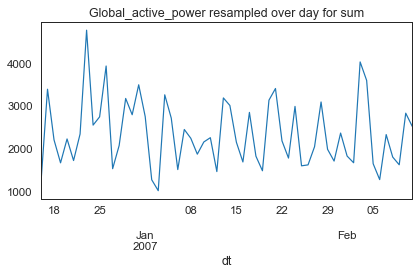

In [17]:
df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum') 
plt.tight_layout()
plt.show()   

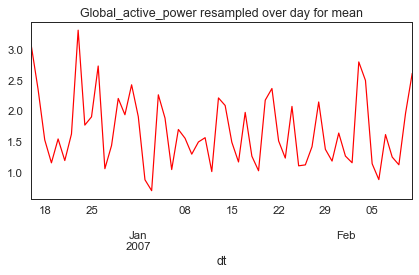

In [18]:
df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean', color='red') 
plt.tight_layout()
plt.show()

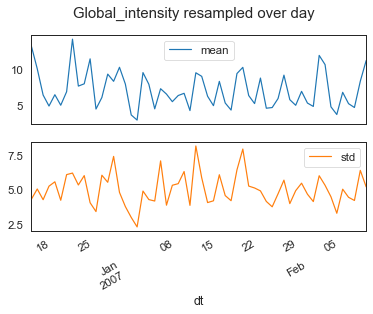

In [19]:
# mean and std of 'Global_intensity' resampled over day 
r = df.Global_intensity.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Global_intensity resampled over day')
plt.show()

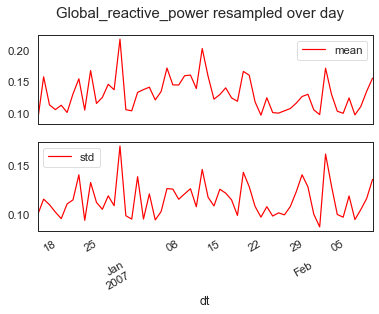

In [20]:
# mean and std of 'Global_reactive_power' resampled over day
r2 = df.Global_reactive_power.resample('D').agg(['mean', 'std'])
r2.plot(subplots = True, title='Global_reactive_power resampled over day', color='red')
plt.show()

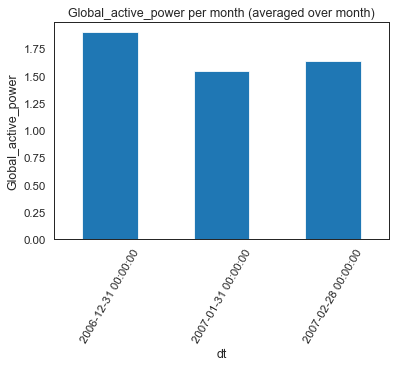

In [21]:
# Sum of 'Global_active_power' resampled over month
df['Global_active_power'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per month (averaged over month)')
plt.show()

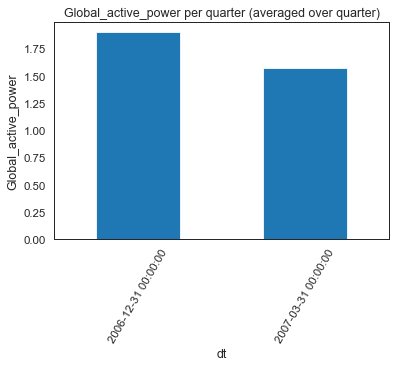

In [22]:
# Mean of 'Global_active_power' resampled over quarter
df['Global_active_power'].resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per quarter (averaged over quarter)')
plt.show()

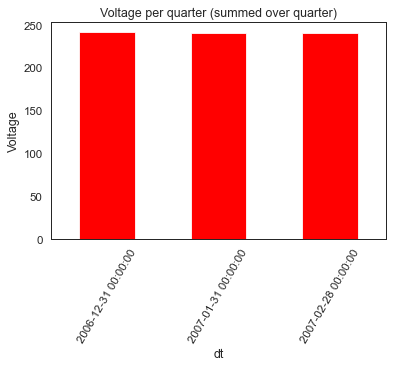

In [23]:
# mean of 'Voltage' resampled over month
df['Voltage'].resample('M').mean().plot(kind='bar', color='red')
plt.xticks(rotation=60)
plt.ylabel('Voltage')
plt.title('Voltage per quarter (summed over quarter)')
plt.show()

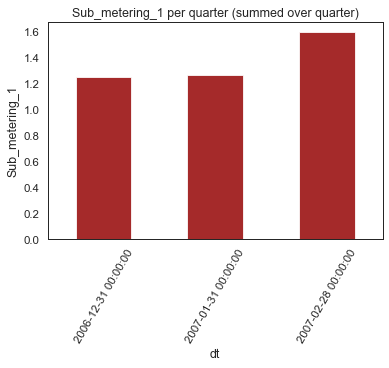

In [24]:
df['Sub_metering_1'].resample('M').mean().plot(kind='bar', color='brown')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_1')
plt.title('Sub_metering_1 per quarter (summed over quarter)')
plt.show()

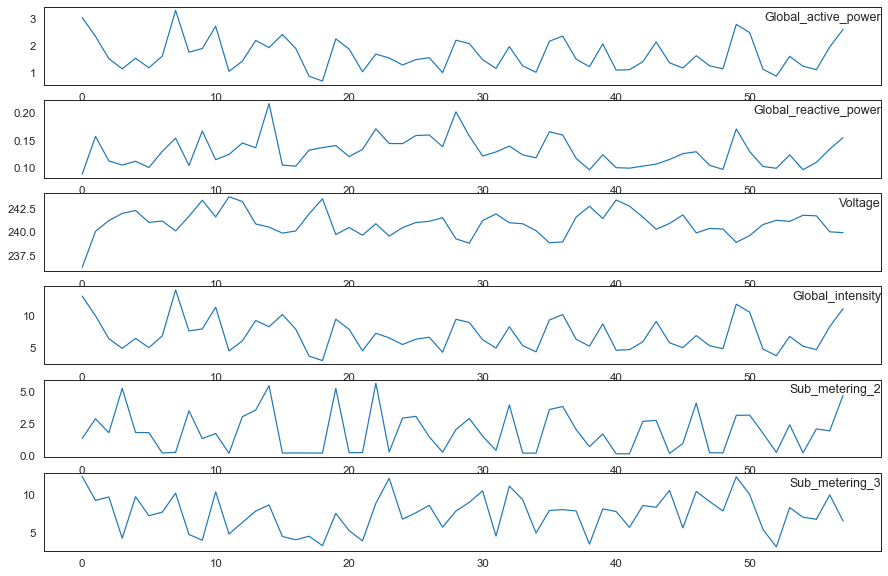

In [25]:
# mean of different features resampled over day 
cols = [0, 1, 2, 3, 5, 6]
i = 1
groups=cols
values = df.resample('D').mean().values
# plot each column
plt.figure(figsize=(15, 10))
for group in groups:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.75, loc='right')
	i += 1
plt.show()

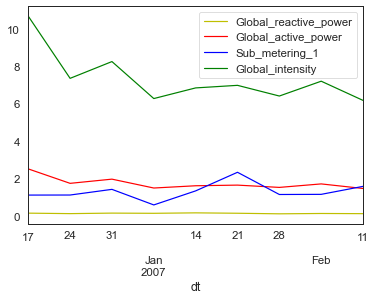

In [26]:
# resampling over week and calculate mean
df.Global_reactive_power.resample('W').mean().plot(color='y', legend=True)
df.Global_active_power.resample('W').mean().plot(color='r', legend=True)
df.Sub_metering_1.resample('W').mean().plot(color='b', legend=True)
df.Global_intensity.resample('W').mean().plot(color='g', legend=True)
plt.show()

# Correlations among features

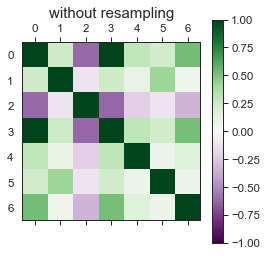

In [27]:
# Correlations of columns
plt.matshow(df.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('without resampling', size=15)
plt.colorbar()
plt.show()

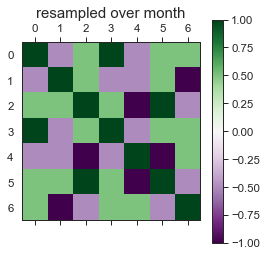

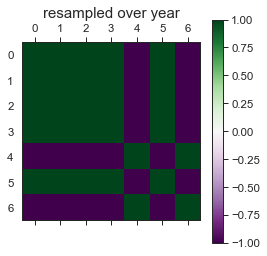

In [28]:
# Correlations of mean of features resampled over months

plt.matshow(df.resample('M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over month', size=15)
plt.colorbar()
plt.margins(0.02)
plt.matshow(df.resample('A').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over year', size=15)
plt.colorbar()
plt.show()

In [29]:
# resampling over hour
df_resample = df.resample('h').mean() 
df_resample.shape

(1368, 7)

In [30]:
df_resample.head()

Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:00:00               4.2229                 0.2290 234.6439   
2006-12-16 18:00:00               3.6322                 0.0800 234.5802   
2006-12-16 19:00:00               3.4002                 0.0852 233.2325   
2006-12-16 20:00:00               3.2686                 0.0751 234.0715   
2006-12-16 21:00:00               3.0565                 0.0767 237.1587   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:00:00           18.1000          0.0000          0.5278   
2006-12-16 18:00:00           15.6000          0.0000          6.7167   
2006-12-16 19:00:00           14.5033          0.0000          1.4333   
2006-12-16 20:00:00           13.9167          0.0000          0.0000   
2006-12-16 21:00:00           13.0467          0.0000          0.4167   

                     Sub_metering_3  
dt                                   
2006-12-16 17:00:00         16.8611  
2006-12-16 18:00:00         16.8667  
2006-12-16 19:00:00         16.6833  
2006-12-16 20:00:00         16.7833  
2006-12-16 21:00:00         17.2167

In [31]:
col = list(df_resample.columns)
col

['Global_active_power',
 'Global_reactive_power',
 'Voltage',
 'Global_intensity',
 'Sub_metering_1',
 'Sub_metering_2',
 'Sub_metering_3']

In [32]:
length = 3
for i in range(length, 0, -1):
    for coll in col:
        df_resample[coll+'(t'+str(-i)+')'] = df_resample[coll].shift(i)

In [33]:
df_resample.head()

Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:00:00               4.2229                 0.2290 234.6439   
2006-12-16 18:00:00               3.6322                 0.0800 234.5802   
2006-12-16 19:00:00               3.4002                 0.0852 233.2325   
2006-12-16 20:00:00               3.2686                 0.0751 234.0715   
2006-12-16 21:00:00               3.0565                 0.0767 237.1587   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:00:00           18.1000          0.0000          0.5278   
2006-12-16 18:00:00           15.6000          0.0000          6.7167   
2006-12-16 19:00:00           14.5033          0.0000          1.4333   
2006-12-16 20:00:00           13.9167          0.0000          0.0000   
2006-12-16 21:00:00           13.0467          0.0000          0.4167   

                     Sub_metering_3  Global_active_power(t-3)  \
dt                                                              
2006-12-16 17:00:00         16.8611                       nan   
2006-12-16 18:00:00         16.8667                       nan   
2006-12-16 19:00:00         16.6833                       nan   
2006-12-16 20:00:00         16.7833                    4.2229   
2006-12-16 21:00:00         17.2167                    3.6322   

                     Global_reactive_power(t-3)  Voltage(t-3)  ...  \
dt                                                             ...   
2006-12-16 17:00:00                         nan           nan  ...   
2006-12-16 18:00:00                         nan           nan  ...   
2006-12-16 19:00:00                         nan           nan  ...   
2006-12-16 20:00:00                      0.2290      234.6439  ...   
2006-12-16 21:00:00                      0.0800      234.5802  ...   

                     Sub_metering_1(t-2)  Sub_metering_2(t-2)  \
dt                                                              
2006-12-16 17:00:00                  nan                  nan   
2006-12-16 18:00:00                  nan                  nan   
2006-12-16 19:00:00               0.0000               0.5278   
2006-12-16 20:00:00               0.0000               6.7167   
2006-12-16 21:00:00               0.0000               1.4333   

                     Sub_metering_3(t-2)  Global_active_power(t-1)  \
dt                                                                   
2006-12-16 17:00:00                  nan                       nan   
2006-12-16 18:00:00                  nan                    4.2229   
2006-12-16 19:00:00              16.8611                    3.6322   
2006-12-16 20:00:00              16.8667                    3.4002   
2006-12-16 21:00:00              16.6833                    3.2686   

                     Global_reactive_power(t-1)  Voltage(t-1)  \
dt                                                              
2006-12-16 17:00:00                         nan           nan   
2006-12-16 18:00:00                      0.2290      234.6439   
2006-12-16 19:00:00                      0.0800      234.5802   
2006-12-16 20:00:00                      0.0852      233.2325   
2006-12-16 21:00:00                      0.0751      234.0715   

                     Global_intensity(t-1)  Sub_metering_1(t-1)  \
dt                                                                
2006-12-16 17:00:00                    nan                  nan   
2006-12-16 18:00:00                18.1000               0.0000   
2006-12-16 19:00:00                15.6000               0.0000   
2006-12-16 20:00:00                14.5033               0.0000   
2006-12-16 21:00:00                13.9167               0.0000   

                     Sub_metering_2(t-1)  Sub_metering_3(t-1)  
dt                                                             
2006-12-16 17:00:00         

In [34]:
df_resample.shape

(1368, 28)

In [35]:
df_resample.dropna(inplace = True)
df_resample.drop(df_resample.columns[[1, 2, 3, 4, 5, 6]], axis = 1, inplace= True)
df_resample.head()

Global_active_power  Global_active_power(t-3)  \
dt                                                                   
2006-12-16 20:00:00               3.2686                    4.2229   
2006-12-16 21:00:00               3.0565                    3.6322   
2006-12-16 22:00:00               2.2001                    3.4002   
2006-12-16 23:00:00               2.0616                    3.2686   
2006-12-17 00:00:00               1.8825                    3.0565   

                     Global_reactive_power(t-3)  Voltage(t-3)  \
dt                                                              
2006-12-16 20:00:00                      0.2290      234.6439   
2006-12-16 21:00:00                      0.0800      234.5802   
2006-12-16 22:00:00                      0.0852      233.2325   
2006-12-16 23:00:00                      0.0751      234.0715   
2006-12-17 00:00:00                      0.0767      237.1587   

                     Global_intensity(t-3)  Sub_metering_1(t-3)  \
dt                                                                
2006-12-16 20:00:00                18.1000               0.0000   
2006-12-16 21:00:00                15.6000               0.0000   
2006-12-16 22:00:00                14.5033               0.0000   
2006-12-16 23:00:00                13.9167               0.0000   
2006-12-17 00:00:00                13.0467               0.0000   

                     Sub_metering_2(t-3)  Sub_metering_3(t-3)  \
dt                                                              
2006-12-16 20:00:00               0.5278              16.8611   
2006-12-16 21:00:00               6.7167              16.8667   
2006-12-16 22:00:00               1.4333              16.6833   
2006-12-16 23:00:00               0.0000              16.7833   
2006-12-17 00:00:00               0.4167              17.2167   

                     Global_active_power(t-2)  Global_reactive_power(t-2)  \
dt                                                                          
2006-12-16 20:00:00                    3.6322                      0.0800   
2006-12-16 21:00:00                    3.4002                      0.0852   
2006-12-16 22:00:00                    3.2686                      0.0751   
2006-12-16 23:00:00                    3.0565                      0.0767   
2006-12-17 00:00:00                    2.2001                      0.0562   

                     ...  Sub_metering_1(t-2)  Sub_metering_2(t-2)  \
dt                   ...                                             
2006-12-16 20:00:00  ...               0.0000               6.7167   
2006-12-16 21:00:00  ...               0.0000               1.4333   
2006-12-16 22:00:00  ...               0.0000               0.0000   
2006-12-16 23:00:00  ...               0.0000               0.4167   
2006-12-17 00:00:00  ...               0.0000               0.1333   

                     Sub_metering_3(t-2)  Global_active_power(t-1)  \
dt                                                                   
2006-12-16 20:00:00              16.8667                    3.4002   
2006-12-16 21:00:00              16.6833                    3.2686   
2006-12-16 22:00:00              16.7833                    3.0565   
2006-12-16 23:00:00              17.2167                    2.2001   
2006-12-17 00:00:00               4.4333                    2.0616   

                     Global_reactive_power(t-1)  Voltage(t-1)  \
dt                                                              
2006-12-16 20:00:00                      0.0852      233.2325   
2006-12-16 21:00:00                      0.0751      234.0715   
2006-12-16 22:00:00                      0.0767      237.1587   
2006-12-16 23:00:00                      0.0562      238.7600   
2006-12-17 00:00:00                      0.0714      240.6197   

                     Global_intensity(t-1)  Sub_metering_1(t-1)  \
dt                                                                
2006-12-16 20:00:00                1

In [36]:
df_resample.shape

(1365, 22)

In [37]:
values = df_resample.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled.shape

(1365, 22)

# Splitting the rest of data to train and validation sets

In [38]:
values = scaled

n_train_time = 1100
train = values[:n_train_time, :]
test = values[n_train_time:, :]

train_X, train_y = train[:, 1:], train[:, 1]
test_X, test_y = test[:, 1:], test[:, 1]

train_X = train_X.reshape((train_X.shape[0], 3, 7))
test_X = test_X.reshape((test_X.shape[0], 3, 7))

print ('Train_X Shape: ',train_X.shape)
print ('Train_y Shape: ',train_y.shape)
print ('Test_X Shape: ',test_X.shape)
print ('Test_y Shape: ',test_y.shape)

Train_X Shape:  (1100, 3, 7)
Train_y Shape:  (1100,)
Test_X Shape:  (265, 3, 7)
Test_y Shape:  (265,)


In [39]:
model = Sequential()
model.add(LSTM(100, input_shape = (train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')

In [40]:
history = model.fit(train_X, train_y, epochs = 100, batch_size = 70, validation_data = (test_X, test_y), verbose = 2, shuffle = False)

Train on 1100 samples, validate on 265 samples
Epoch 1/100
 - 2s - loss: 0.0510 - val_loss: 0.0244
Epoch 2/100
 - 0s - loss: 0.0195 - val_loss: 0.0133
Epoch 3/100
 - 0s - loss: 0.0126 - val_loss: 0.0092
Epoch 4/100
 - 0s - loss: 0.0088 - val_loss: 0.0070
Epoch 5/100
 - 0s - loss: 0.0068 - val_loss: 0.0054
Epoch 6/100
 - 0s - loss: 0.0057 - val_loss: 0.0041
Epoch 7/100
 - 0s - loss: 0.0043 - val_loss: 0.0032
Epoch 8/100
 - 0s - loss: 0.0036 - val_loss: 0.0026
Epoch 9/100
 - 0s - loss: 0.0029 - val_loss: 0.0021
Epoch 10/100
 - 0s - loss: 0.0024 - val_loss: 0.0017
Epoch 11/100
 - 0s - loss: 0.0024 - val_loss: 0.0015
Epoch 12/100
 - 0s - loss: 0.0021 - val_loss: 0.0014
Epoch 13/100
 - 0s - loss: 0.0021 - val_loss: 0.0014
Epoch 14/100
 - 0s - loss: 0.0021 - val_loss: 0.0012
Epoch 15/100
 - 0s - loss: 0.0019 - val_loss: 0.0011
Epoch 16/100
 - 0s - loss: 0.0017 - val_loss: 0.0011
Epoch 17/100
 - 0s - loss: 0.0017 - val_loss: 9.4873e-04
Epoch 18/100
 - 0s - loss: 0.0016 - val_loss: 9.1620e-04


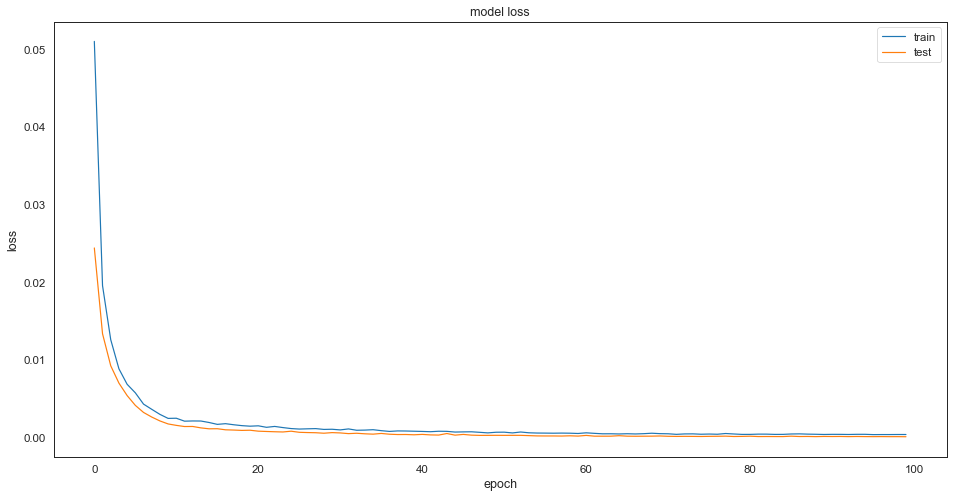

In [41]:
# loss chart
plt.figure(figsize = (16, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [42]:

# prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))
# invert scaling for forecast
con_yhat = np.concatenate((yhat, test_X[:, -21:]), axis = 1)
inv_yhat = scaler.inverse_transform(con_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((test_y.shape[0], 1))
con_y = np.concatenate((test_y, test_X[:, -21:]), axis=1)
inv_y = scaler.inverse_transform(con_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.043


In [43]:
del df
dataset = pd.read_csv('household_power_consumption.txt',
                   sep=';',                            # separateur = ;
                   nrows=82000, 
                   header=0,                           # ligne des header = 1Ã¨re ligne
                   low_memory=False,                   # parsing complet
                   infer_datetime_format=True,         # parsing des dates
                   parse_dates={'datetime':[0,1]},     # les dates se parsent via les 2 premiÃ¨res colonnes
                   index_col=['datetime'])             # l'index sera crÃ©e dans une colonne 'datetime'

In [44]:
dataset.loc[dataset.Sub_metering_3.isnull()].head()

Global_active_power Global_reactive_power Voltage  \
datetime                                                                
2006-12-21 11:23:00                   ?                     ?       ?   
2006-12-21 11:24:00                   ?                     ?       ?   
2006-12-30 10:08:00                   ?                     ?       ?   
2006-12-30 10:09:00                   ?                     ?       ?   
2007-01-14 18:36:00                   ?                     ?       ?   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
datetime                                                             
2006-12-21 11:23:00                ?              ?              ?   
2006-12-21 11:24:00                ?              ?              ?   
2006-12-30 10:08:00                ?              ?              ?   
2006-12-30 10:09:00                ?              ?              ?   
2007-01-14 18:36:00                ?              ?              ?   

                     Sub_metering_3  
datetime                             
2006-12-21 11:23:00             nan  
2006-12-21 11:24:00             nan  
2006-12-30 10:08:00             nan  
2006-12-30 10:09:00             nan  
2007-01-14 18:36:00             nan

In [45]:
dataset = dataset.dropna()
dataset = dataset.astype('float32')

In [46]:
daily_groups = dataset.resample('D')
weekly_groups = dataset.resample('W')

daily_data = daily_groups.sum()
weekly_data = weekly_groups.sum()

In [47]:
daily_data.head()

Global_active_power  Global_reactive_power     Voltage  \
datetime                                                             
2006-12-16            1209.1760                34.9220  93552.5312   
2006-12-17            3390.4600               226.0060 345725.3125   
2006-12-18            2203.8259               161.7920 347373.6250   
2006-12-19            1666.1940               150.9420 348479.0000   
2006-12-20            2225.7480               160.9980 348923.6250   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
datetime                                                                      
2006-12-16         5180.7998          0.0000        546.0000       4926.0000  
2006-12-17        14398.5996       2033.0000       4187.0000      13341.0000  
2006-12-18         9247.2002       1063.0000       2621.0000      14018.0000  
2006-12-19         7094.0000        839.0000       7602.0000       6197.0000  
2006-12-20         9313.0000          0.0000       2648.0000      14063.0000

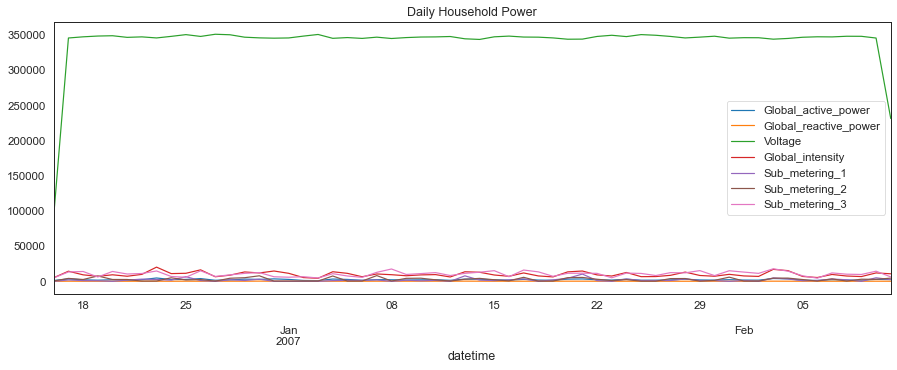

In [48]:
ax = daily_data.plot(title='Daily Household Power', figsize=(15,5))

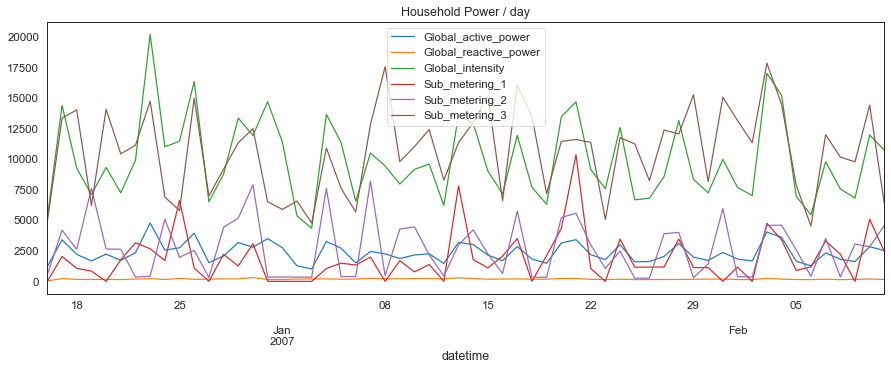

In [49]:
ddata = daily_data.drop(columns=['Voltage'])
ax= ddata.plot(title='Household Power / day', figsize=(15,5))

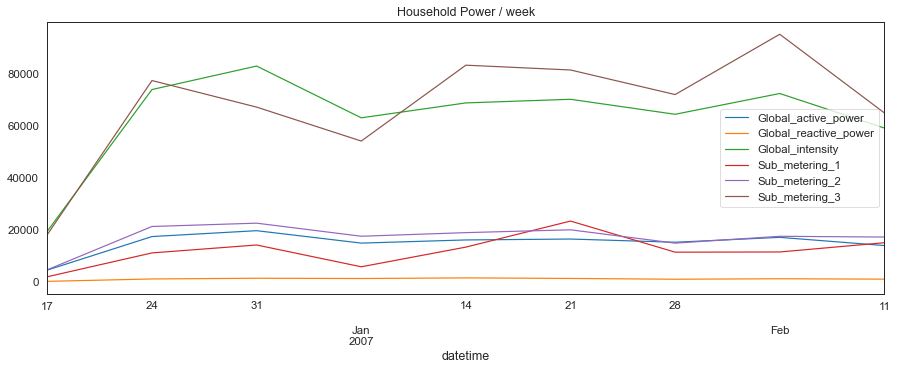

In [50]:
wkdata = weekly_data.drop(columns=['Voltage'])
ax= wkdata.plot(title='Household Power / week', figsize=(15,5))

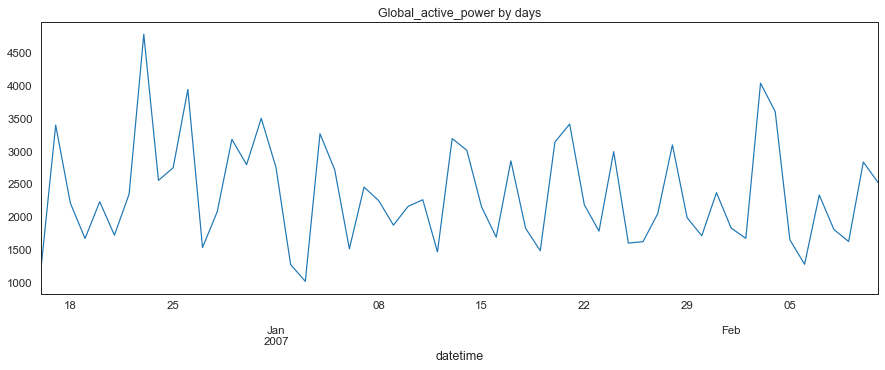

In [51]:
ax = daily_data.Global_active_power.plot(title='Global_active_power by days', figsize=(15,5))

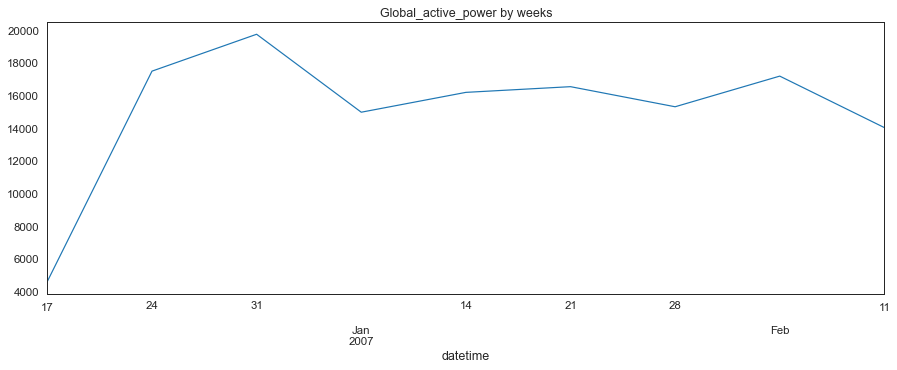

In [52]:
ax= weekly_data.Global_active_power.plot(title='Global_active_power by weeks', figsize=(15,5))

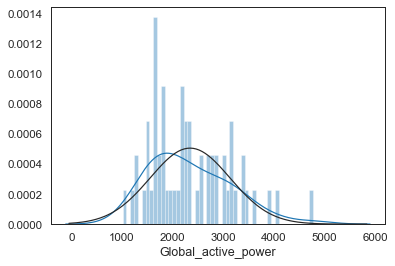

In [53]:
ax = sns.distplot(daily_data['Global_active_power'], fit=norm, bins=50, kde=True);

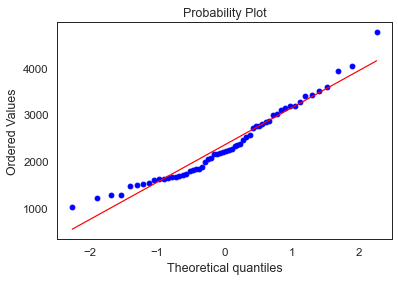

In [54]:
ax = stats.probplot(daily_data['Global_active_power'], plot=pyplot)

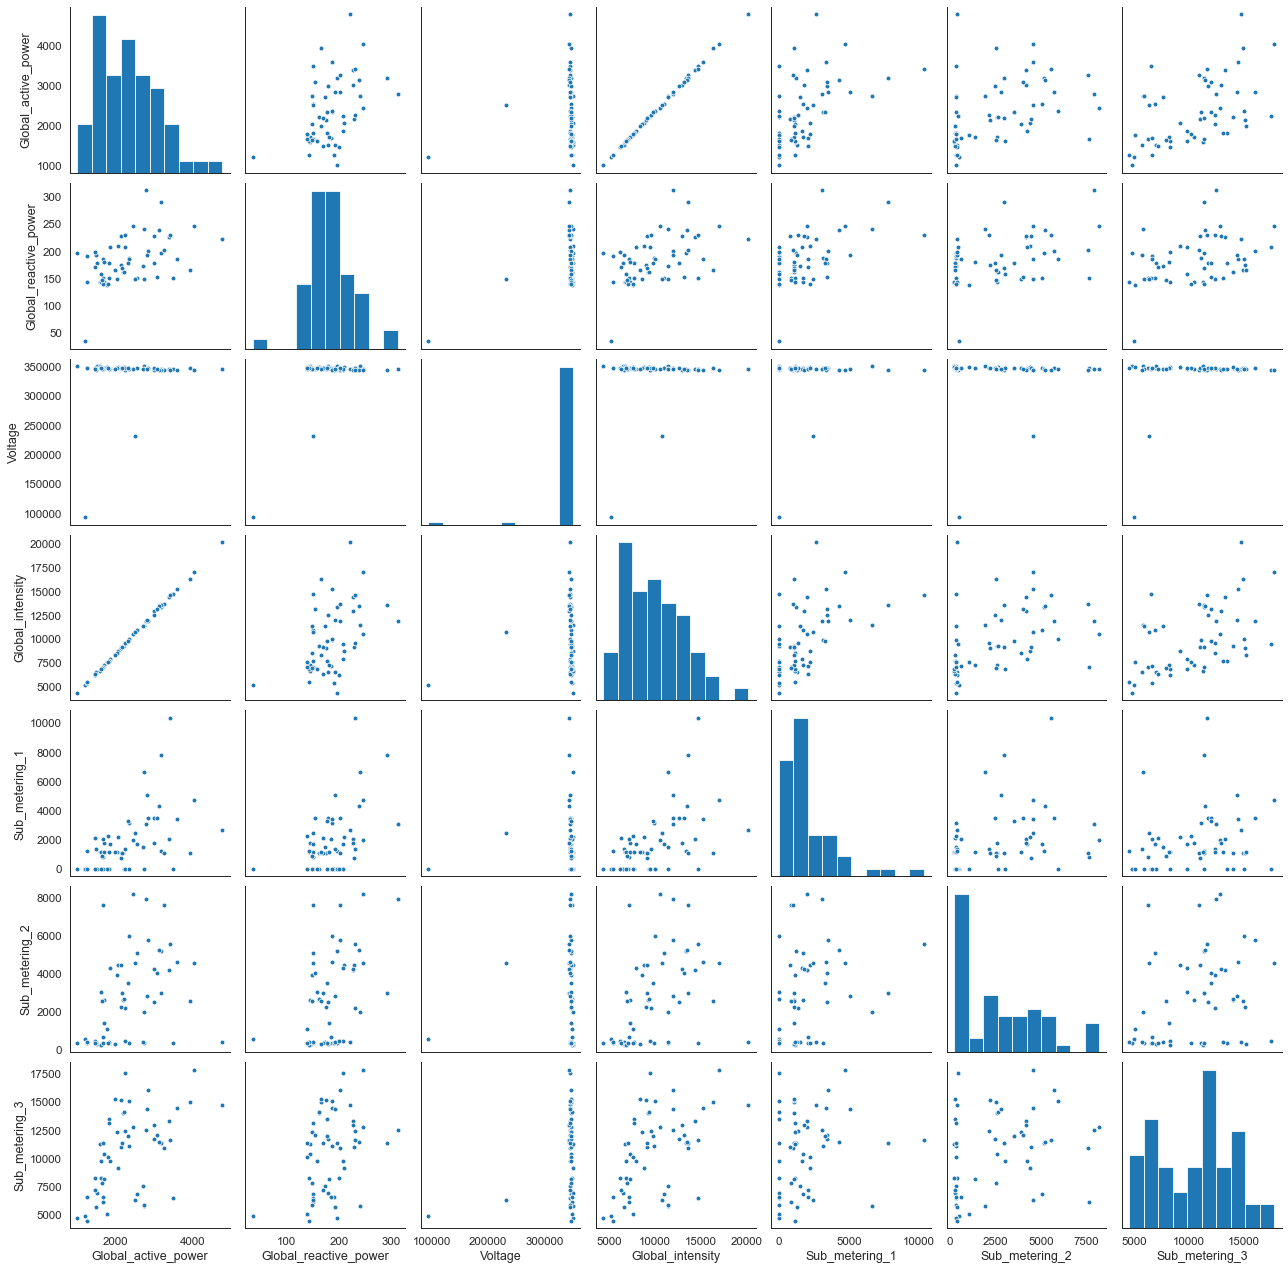

In [55]:
ax = sns.pairplot(daily_data, height = 2.5)

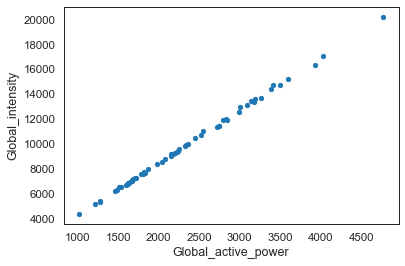

In [56]:
ax = daily_data.plot.scatter(x='Global_active_power', y='Global_intensity')

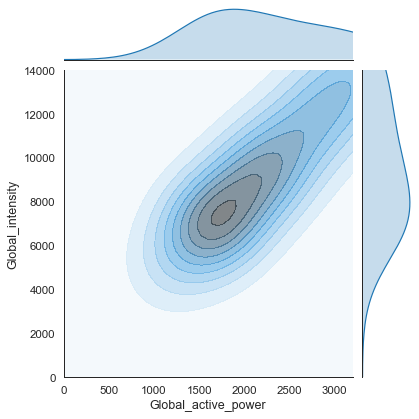

In [57]:
ax=sns.jointplot(daily_data['Global_active_power'], daily_data['Global_intensity'], kind='kde', 
                   joint_kws={'alpha':0.5}, 
                   xlim=(0, 3200), 
                   ylim=(0, 14000),
                   height=6)

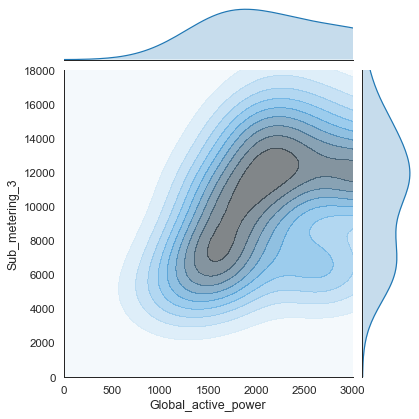

In [58]:
ax=sns.jointplot(daily_data['Global_active_power'], daily_data['Sub_metering_3'], kind='kde', 
                   joint_kws={'alpha':0.5}, 
                   xlim=(0, 3000), 
                   ylim=(0, 18000),
                   height=6)

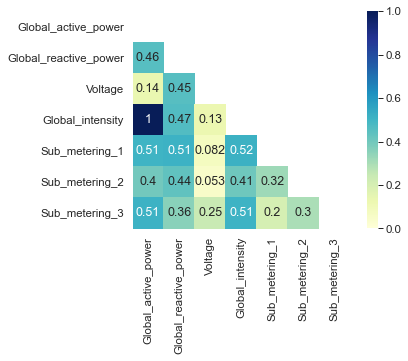

In [59]:
pearson = daily_data.corr(method='pearson')
mask = np.zeros_like(pearson)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(pearson, vmax=1, vmin=0, square=True, cbar=True, annot=True, cmap="YlGnBu", mask=mask);

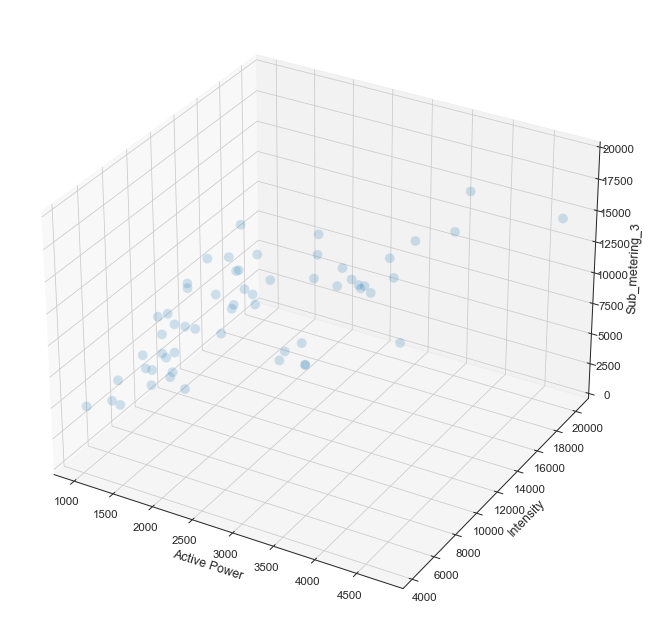

In [60]:
# 3D plotting
fig = pyplot.figure(figsize=(80, 80))
ax = fig.add_subplot(666, projection='3d')
xs = daily_data['Global_active_power']
ys = daily_data['Global_intensity']
zs = daily_data['Sub_metering_3']
ax.scatter(xs, ys, zs, s=100, alpha=0.2, edgecolors='w')
ax.set_xlabel('Active Power')
ax.set_ylabel('Intensity')
ax.set_zlabel('Sub_metering_3')
ax.set(zlim=(0, 20000))
pyplot.show()

In [61]:
del dataset

df = pd.read_csv('household_power_consumption.txt', sep=';', nrows=82000, 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

## Dealing with missing values  'nan' with a test statistic

In [62]:
droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
        #print(df.iloc[:,j].unique())
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [63]:
for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

##Â * Below I resample over day, and show the sum and mean of Global_active_power. It is seen that mean and sum of resampled data set, have similar structure.

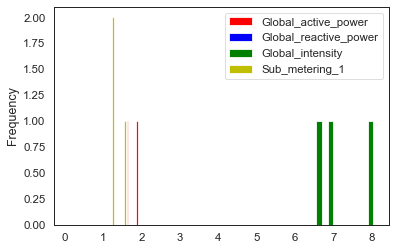

In [64]:
# hist plot of the mean of different feature resampled over month 
df.Global_active_power.resample('M').mean().plot(kind='hist', color='r', legend=True )
df.Global_reactive_power.resample('M').mean().plot(kind='hist',color='b', legend=True)
df.Global_intensity.resample('M').mean().plot(kind='hist', color='g', legend=True)
df.Sub_metering_1.resample('M').mean().plot(kind='hist', color='y', legend=True)
plt.show()

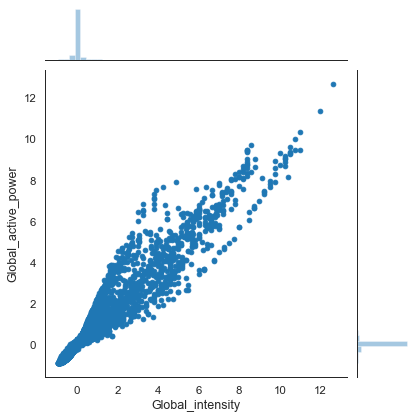

In [65]:
# correlation between 'Global_intensity', 'Global_active_power'
data_returns = df.pct_change()
sns.jointplot(x='Global_intensity', y='Global_active_power', data=data_returns)  

plt.show()

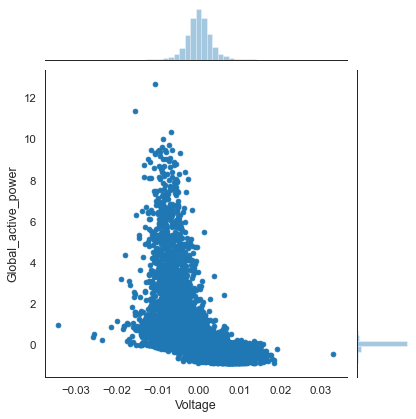

In [66]:
# correlation between 'Voltage' and  'Global_active_power'
sns.jointplot(x='Voltage', y='Global_active_power', data=data_returns)  
plt.show()

### * From above two plots it is seen that 'Global_intensity' and 'Global_active_power' correlated. But 'Voltage', 'Global_active_power' are less correlated. 

In [67]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [68]:
# resampe by hour
df_resample = df.resample('h').mean() 
df_resample.shape

(1368, 7)

In [69]:
# scale features in range of [0,1].
values = df_resample.values 
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised data
reframed = series_to_supervised(scaled, 1, 1)
# drop column not to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1     0.6822     0.3539     0.2642     0.6750     0.0000     0.0132   
2     0.5809     0.0760     0.2613     0.5762     0.0000     0.1677   
3     0.5411     0.0857     0.1981     0.5329     0.0000     0.0358   
4     0.5186     0.0668     0.2374     0.5097     0.0000     0.0000   
5     0.4822     0.0697     0.3821     0.4753     0.0000     0.0104   

   var7(t-1)  var1(t)  
1     0.8977   0.5809  
2     0.8980   0.5411  
3     0.8882   0.5186  
4     0.8935   0.4822  
5     0.9166   0.3354  


In [70]:
del df

df = pd.read_csv('household_power_consumption.txt',
                delimiter = ';', nrows=82000)

In [71]:
print('Number of rows and columns:', df.shape)

Number of rows and columns: (82000, 9)


In [72]:
# Merge Date and Time 
# Convert Global active power to numeric
# Create weekday feature --      0 = weekend  and  1 = weekday

In [73]:
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

df['Global_active_power'] = pd.to_numeric(df['Global_active_power'],
                                         errors = 'coerce')

df = df.dropna(subset = ['Global_active_power'])

df['date_time'] = pd.to_datetime(df['date_time'])

df['year'] = df['date_time'].apply(lambda x: x.year)
df['quarter'] = df['date_time'].apply(lambda x:x.quarter)
df['month'] = df['date_time'].apply(lambda x:x.month)
df['day'] = df['date_time'].apply(lambda x:x.day)

df = df.loc[:,['date_time', 'Global_active_power', 
               'year', 'quarter', 'month', 'day']]

df.sort_values('date_time', inplace = True,
              ascending = True)

df = df.reset_index(drop = True)

df['weekday'] = df.apply(lambda row:row['date_time'].weekday(), axis = 1)
df['weekday'] = (df['weekday'] < 5).astype(int)


In [74]:
print('Number of rows and columns after pre-proc:', df.shape)

print('Time series starts:', df.date_time.min())
print('Time series end:', df.date_time.max())

Number of rows and columns after pre-proc: (81994, 7)
Time series starts: 2006-12-16 17:24:00
Time series end: 2007-12-01 23:59:00


In [75]:
# p statistics value 
# H0 = normal distribution   ---   p <= a, reject H0, not normal  and  p > a, fail to reject H0

In [76]:
stat, p = stats.normaltest(df.Global_active_power)

print('statistics = %.3f, p = %.3f' % (stat, p))

alpha = 0.5
if p > alpha:
    print('Data appears Gaussian (fail to reject H0)')
else:
    print('Data does not appear Gaussian (reject H0)')

statistics = 14616.495, p = 0.000
Data does not appear Gaussian (reject H0)


Kurtosis of normal dist: 1.5389289955160779
Skewness of normal distribution: 1.144984680189571


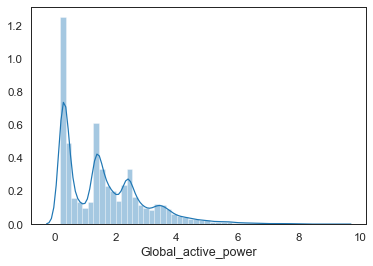

In [77]:
# Kurtosis & Skewness   .   distance from normal 

sns.distplot(df.Global_active_power);
print('Kurtosis of normal dist: {}'.format(stats.kurtosis(df.Global_active_power)))
print('Skewness of normal distribution: {}'.format(stats.skew(df.Global_active_power)))

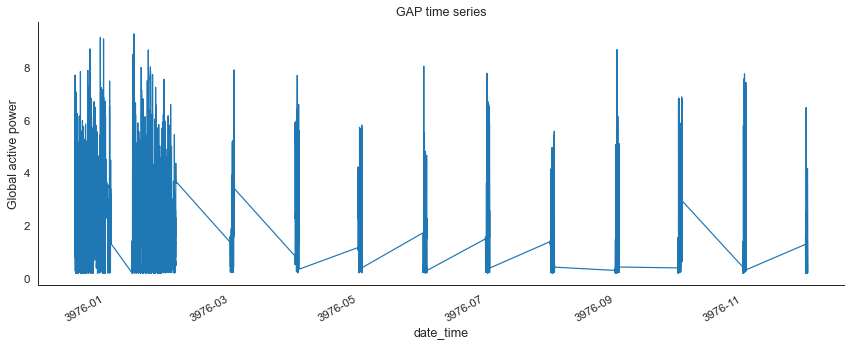

In [78]:
# Time series plot 

# Extract 2 cols 
    # index date 
df1 = df.loc[:, ['date_time', 'Global_active_power']]
df1.set_index('date_time', inplace = True)

# plot 
df1.plot(figsize = (12, 5))

plt.ylabel('Global active power')
plt.title('GAP time series')
plt.legend().set_visible(False)
plt.tight_layout()
sns.despine(top = True)
plt.show();

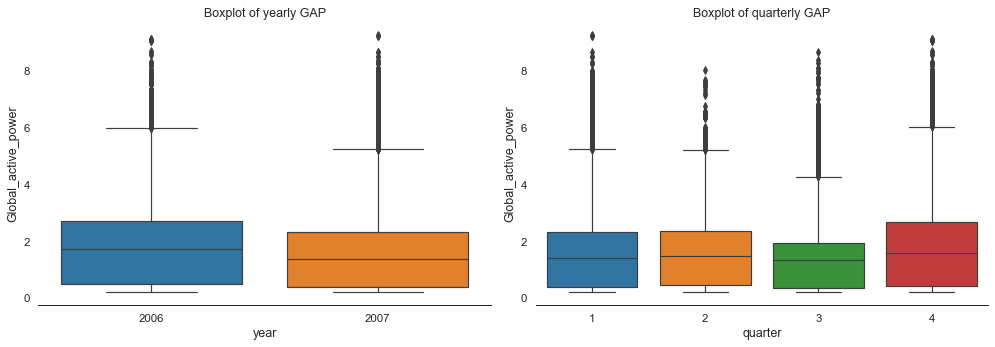

In [79]:
# Quarterly vs. Yearly GAP 

plt.figure(figsize = (14, 5))
plt.subplot(1, 2, 1)
plt.subplots_adjust(wspace = 0.2)
sns.boxplot(x = 'year', y = 'Global_active_power', data = df)
plt.xlabel('year')
plt.title('Boxplot of yearly GAP')

plt.subplot(1, 2, 2)
sns.boxplot(x = 'quarter', y = 'Global_active_power', data = df)
plt.xlabel('quarter')
plt.title('Boxplot of quarterly GAP')
sns.despine(left = True)
plt.tight_layout();

count   mean    std    min    25%    50%    75%  \
Global_active_power 81994.0000 1.6582 1.3420 0.1940 0.3980 1.4260 2.4220   

                       max  
Global_active_power 9.2720

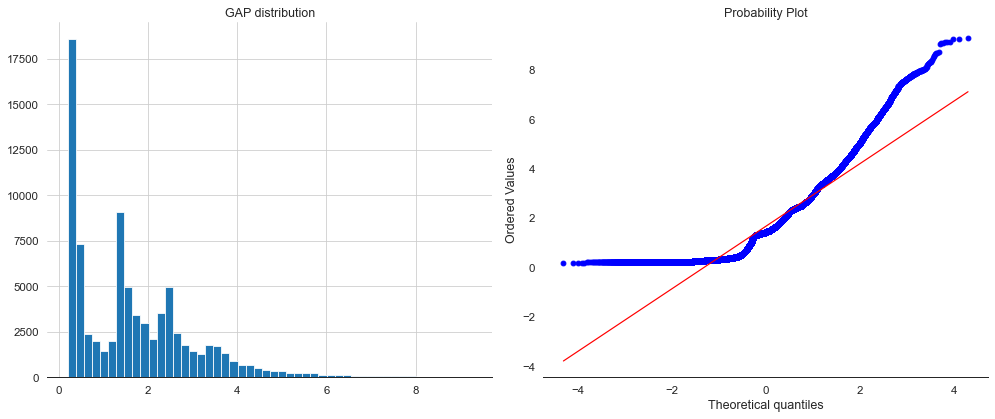

In [80]:
# GAP distribution 

plt.figure(figsize = (14, 6))
plt.subplot(1, 2, 1)
df['Global_active_power'].hist(bins = 50)
plt.title('GAP distribution')

plt.subplot(1, 2, 2)
stats.probplot(df['Global_active_power'], plot = plt);
sns.despine(left = True)
plt.tight_layout()
df1.describe().T

In [81]:
del df
consumption = pd.read_csv('household_power_consumption.txt', sep = ';', nrows=82000, parse_dates= ['Date'], infer_datetime_format=True, low_memory=False,  na_values=['nan','?'])

In [82]:
consumption = consumption.dropna()

In [83]:
mean_consumption_gby_date = consumption.groupby(['Date']).mean()

Text(0.5, 1.0, 'Sub_metering_3')

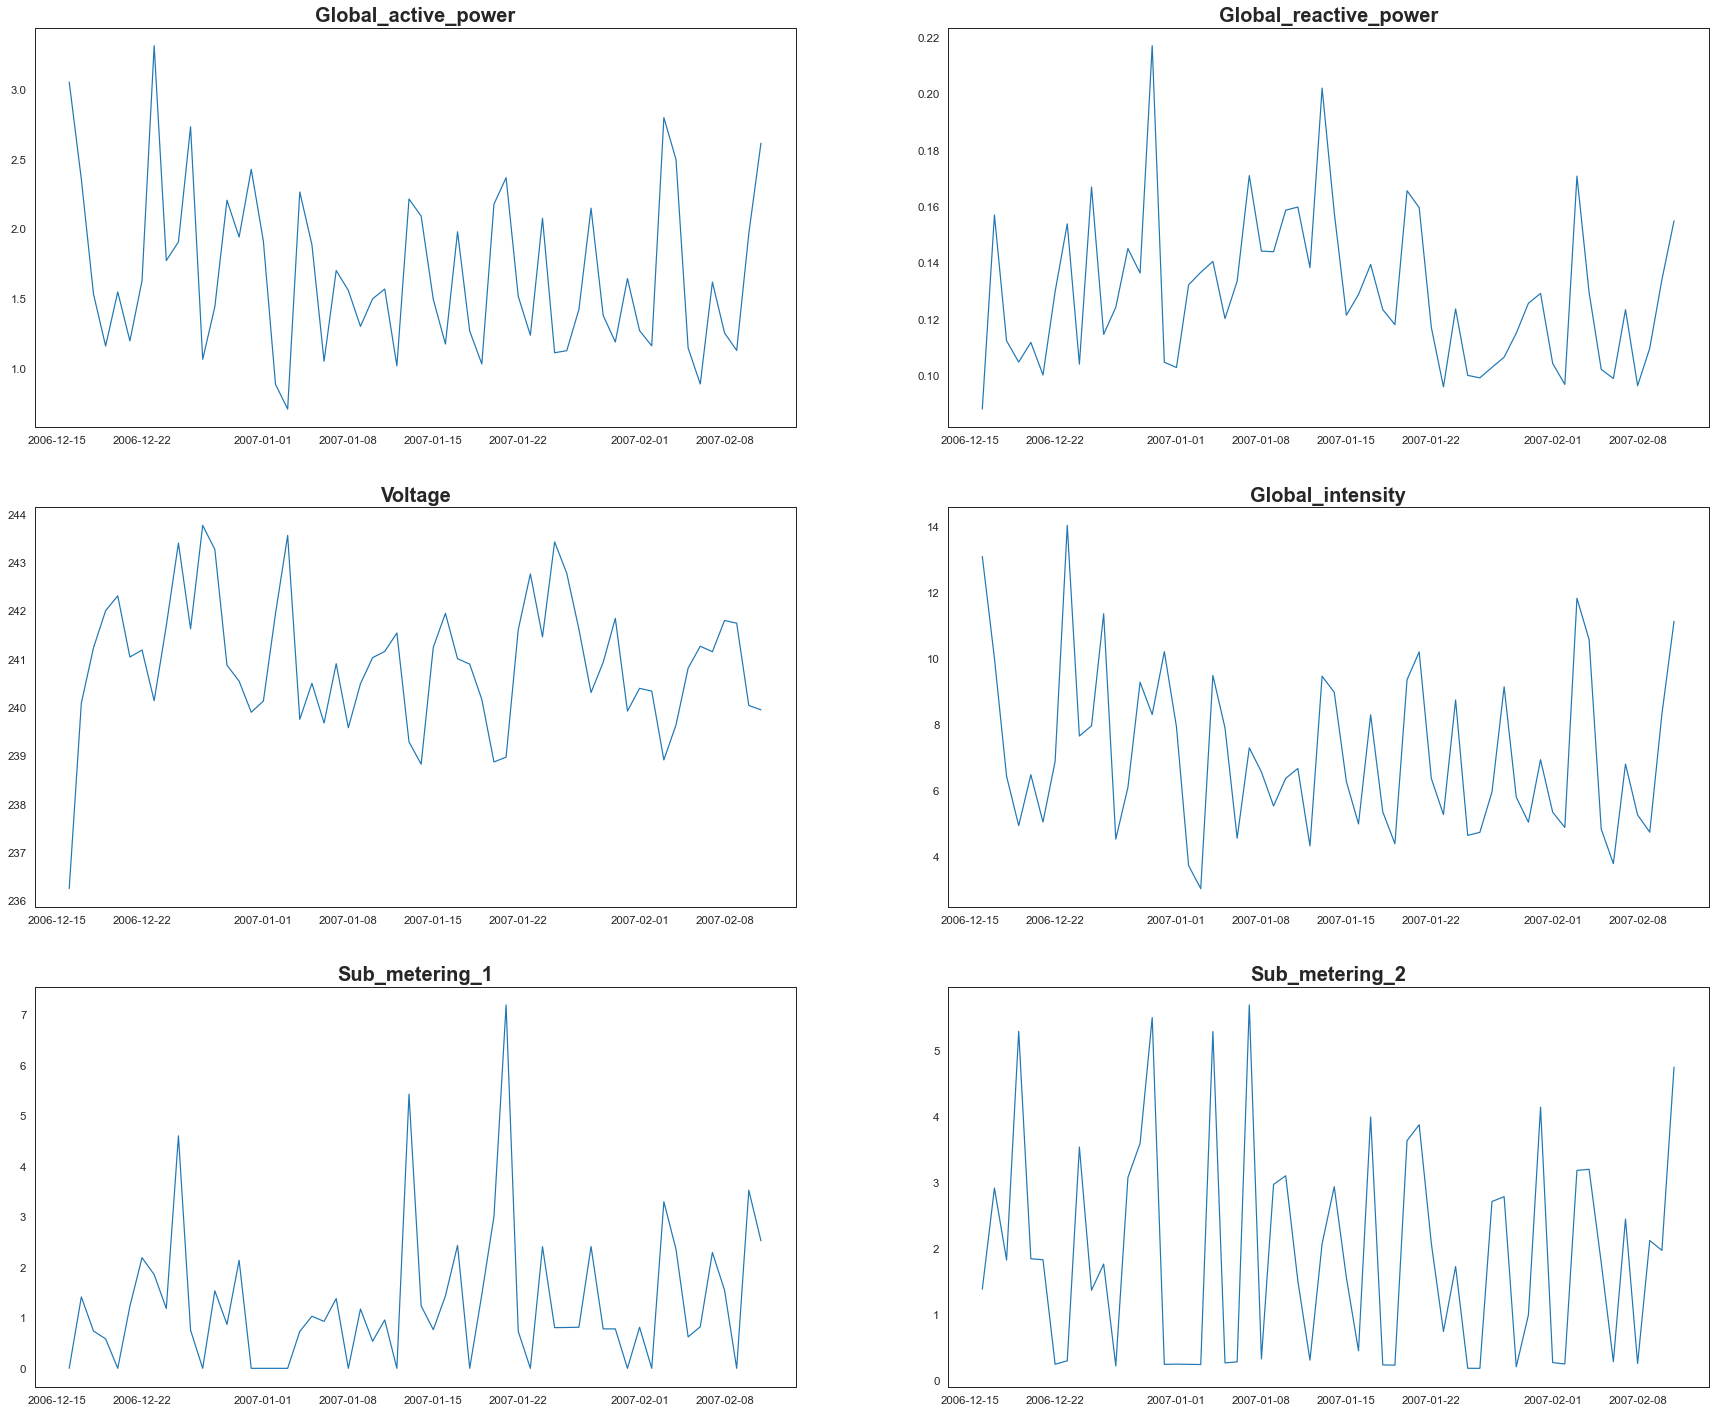

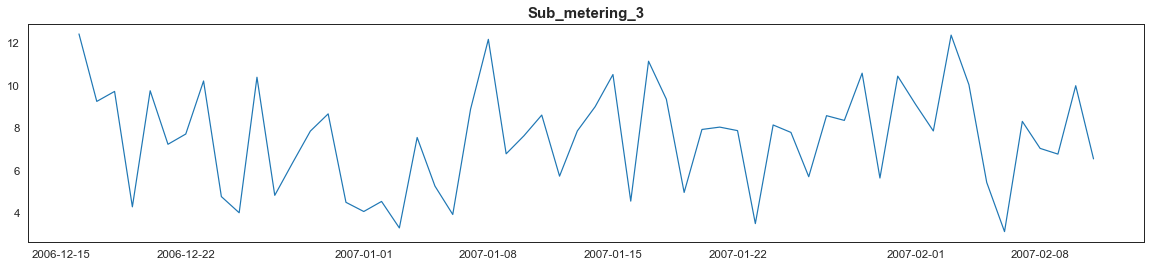

In [84]:
fig, axs = plt.subplots(3, 2, figsize = (30, 25))
columns = mean_consumption_gby_date.columns
axs[0, 0].plot(mean_consumption_gby_date[columns[0]])
axs[0, 0].set_title(columns[0], fontweight = 'bold', size = 20)

axs[0, 1].plot(mean_consumption_gby_date[columns[1]])
axs[0, 1].set_title(columns[1], fontweight = 'bold', size = 20)

axs[1, 0].plot(mean_consumption_gby_date[columns[2]])
axs[1, 0].set_title(columns[2], fontweight = 'bold', size = 20)

axs[1, 1].plot(mean_consumption_gby_date[columns[3]])
axs[1, 1].set_title(columns[3], fontweight = 'bold', size = 20)

axs[2, 0].plot(mean_consumption_gby_date[columns[4]])
axs[2, 0].set_title(columns[4], fontweight = 'bold', size = 20)

axs[2, 1].plot(mean_consumption_gby_date[columns[5]])
axs[2, 1].set_title(columns[5], fontweight = 'bold', size = 20)

fig, axs = plt.subplots( figsize = (20, 4))
axs.plot(mean_consumption_gby_date[columns[6]])
axs.set_title(columns[6], fontweight = 'bold', size = 15)

## Average consumption in each month

In [85]:
mean_consumption_gby_month = consumption.groupby(consumption['Date'].dt.strftime('%B')).mean()
reorderlist = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December' ]
mean_consumption_gby_month = mean_consumption_gby_month.reindex(reorderlist)

Text(0.5, 1.0, 'Sub_metering_3')

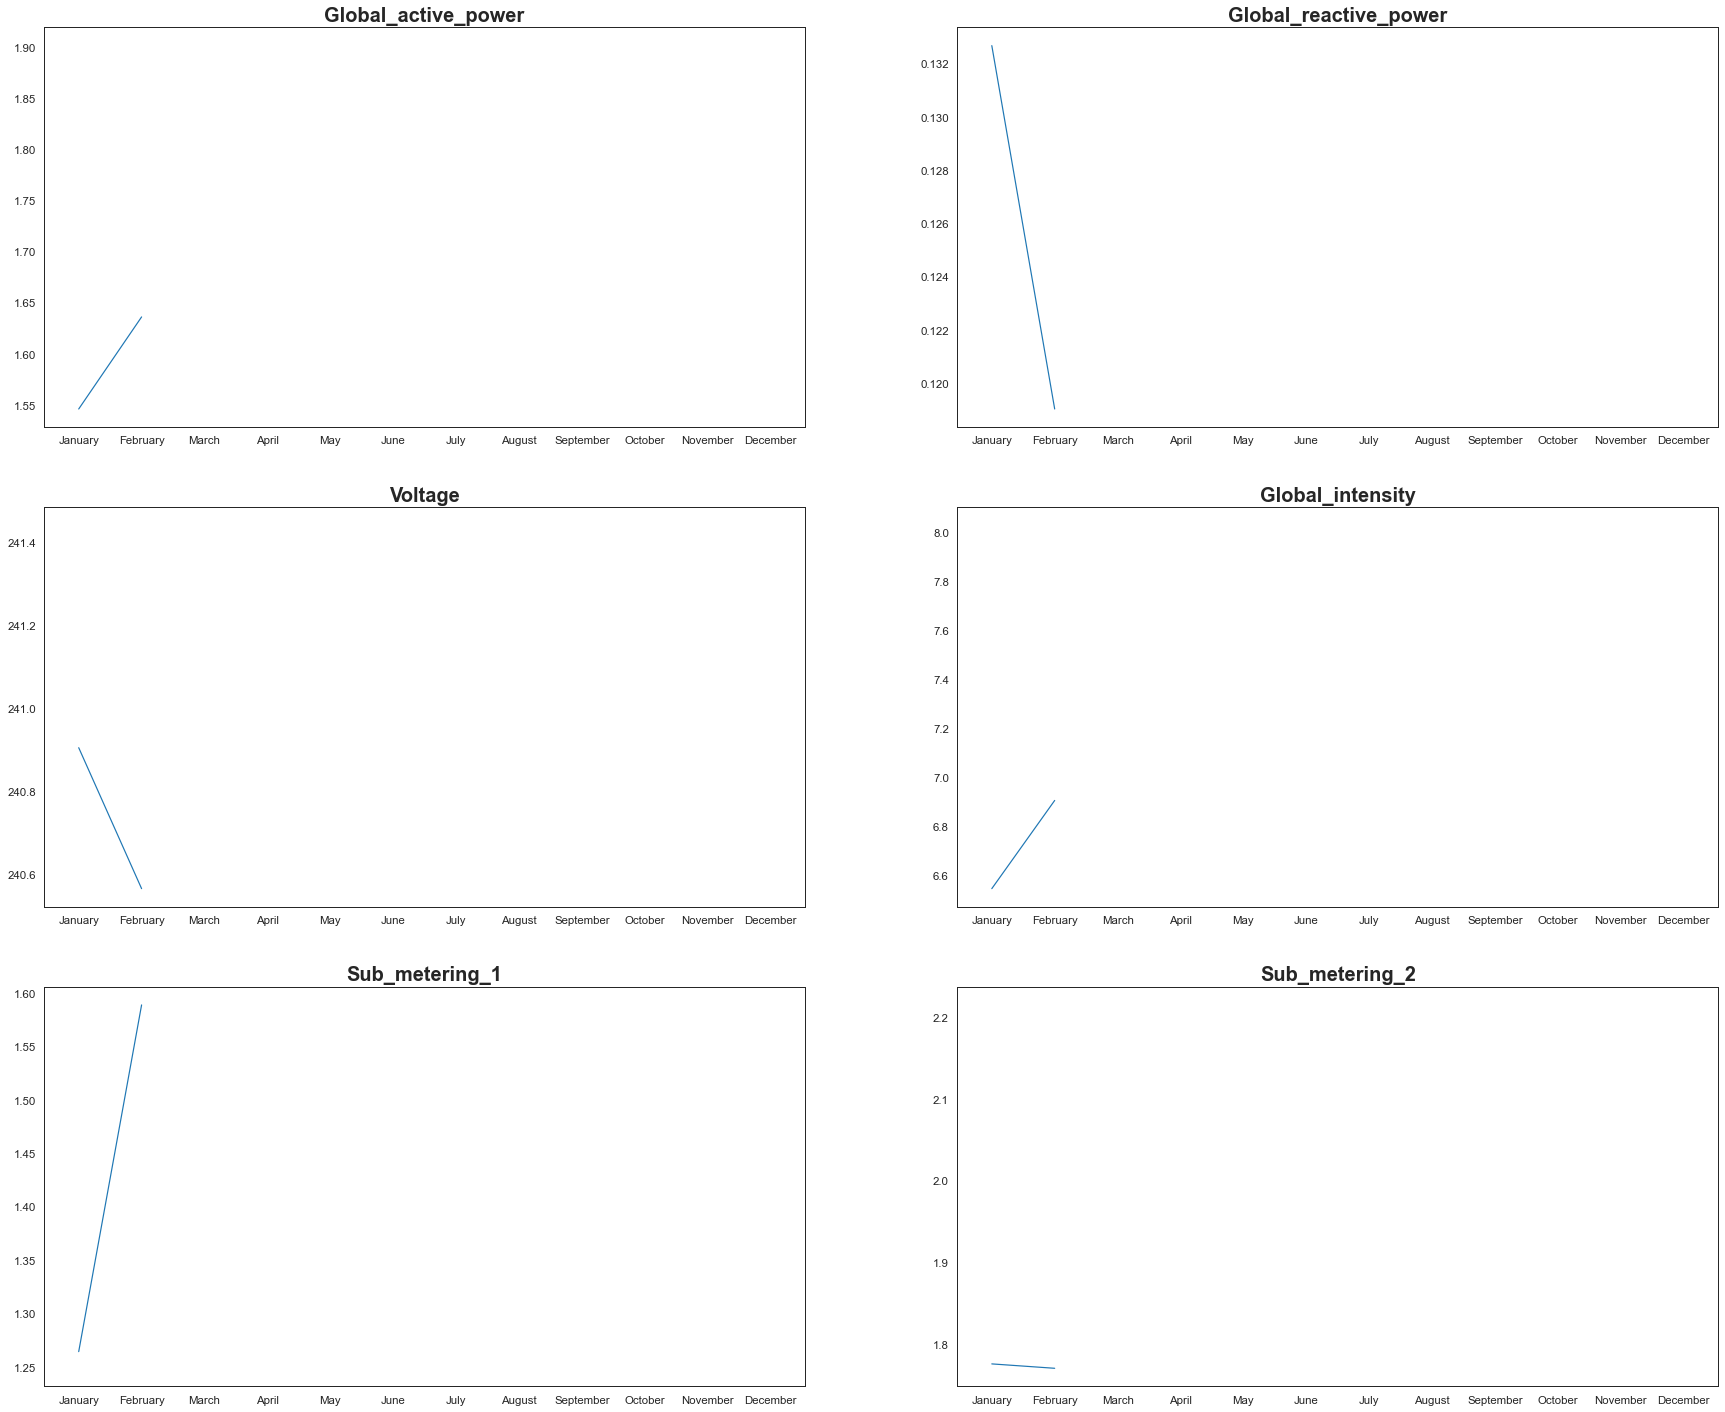

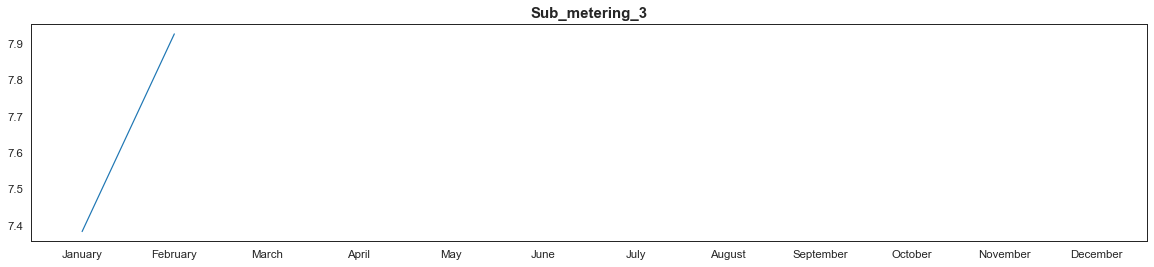

In [86]:
fig, axs = plt.subplots(3, 2, figsize = (30, 25))
columns = mean_consumption_gby_month.columns

axs[0, 0].plot(mean_consumption_gby_month[columns[0]])
axs[0, 0].set_title(columns[0], fontweight = 'bold', size = 20)

axs[0, 1].plot(mean_consumption_gby_month[columns[1]])
axs[0, 1].set_title(columns[1], fontweight = 'bold', size = 20)

axs[1, 0].plot(mean_consumption_gby_month[columns[2]])
axs[1, 0].set_title(columns[2], fontweight = 'bold', size = 20)

axs[1, 1].plot(mean_consumption_gby_month[columns[3]])
axs[1, 1].set_title(columns[3], fontweight = 'bold', size = 20)


axs[2, 0].plot(mean_consumption_gby_month[columns[4]])
axs[2, 0].set_title(columns[4], fontweight = 'bold', size = 20)

axs[2, 1].plot(mean_consumption_gby_month[columns[5]])
axs[2, 1].set_title(columns[5], fontweight = 'bold', size = 20)

fig, axs = plt.subplots( figsize = (20, 4))
axs.plot(mean_consumption_gby_month[columns[6]])
axs.set_title(columns[6], fontweight = 'bold', size = 15)

In [87]:
consumption_2 = pd.read_csv('household_power_consumption.txt', sep=';', nrows=82000, 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

## Average consumption of each day in a month

In [88]:
mean_consumption_gby_day_month = consumption_2.groupby(consumption_2.index.day).mean()

Text(0.5, 1.0, 'Sub_metering_3')

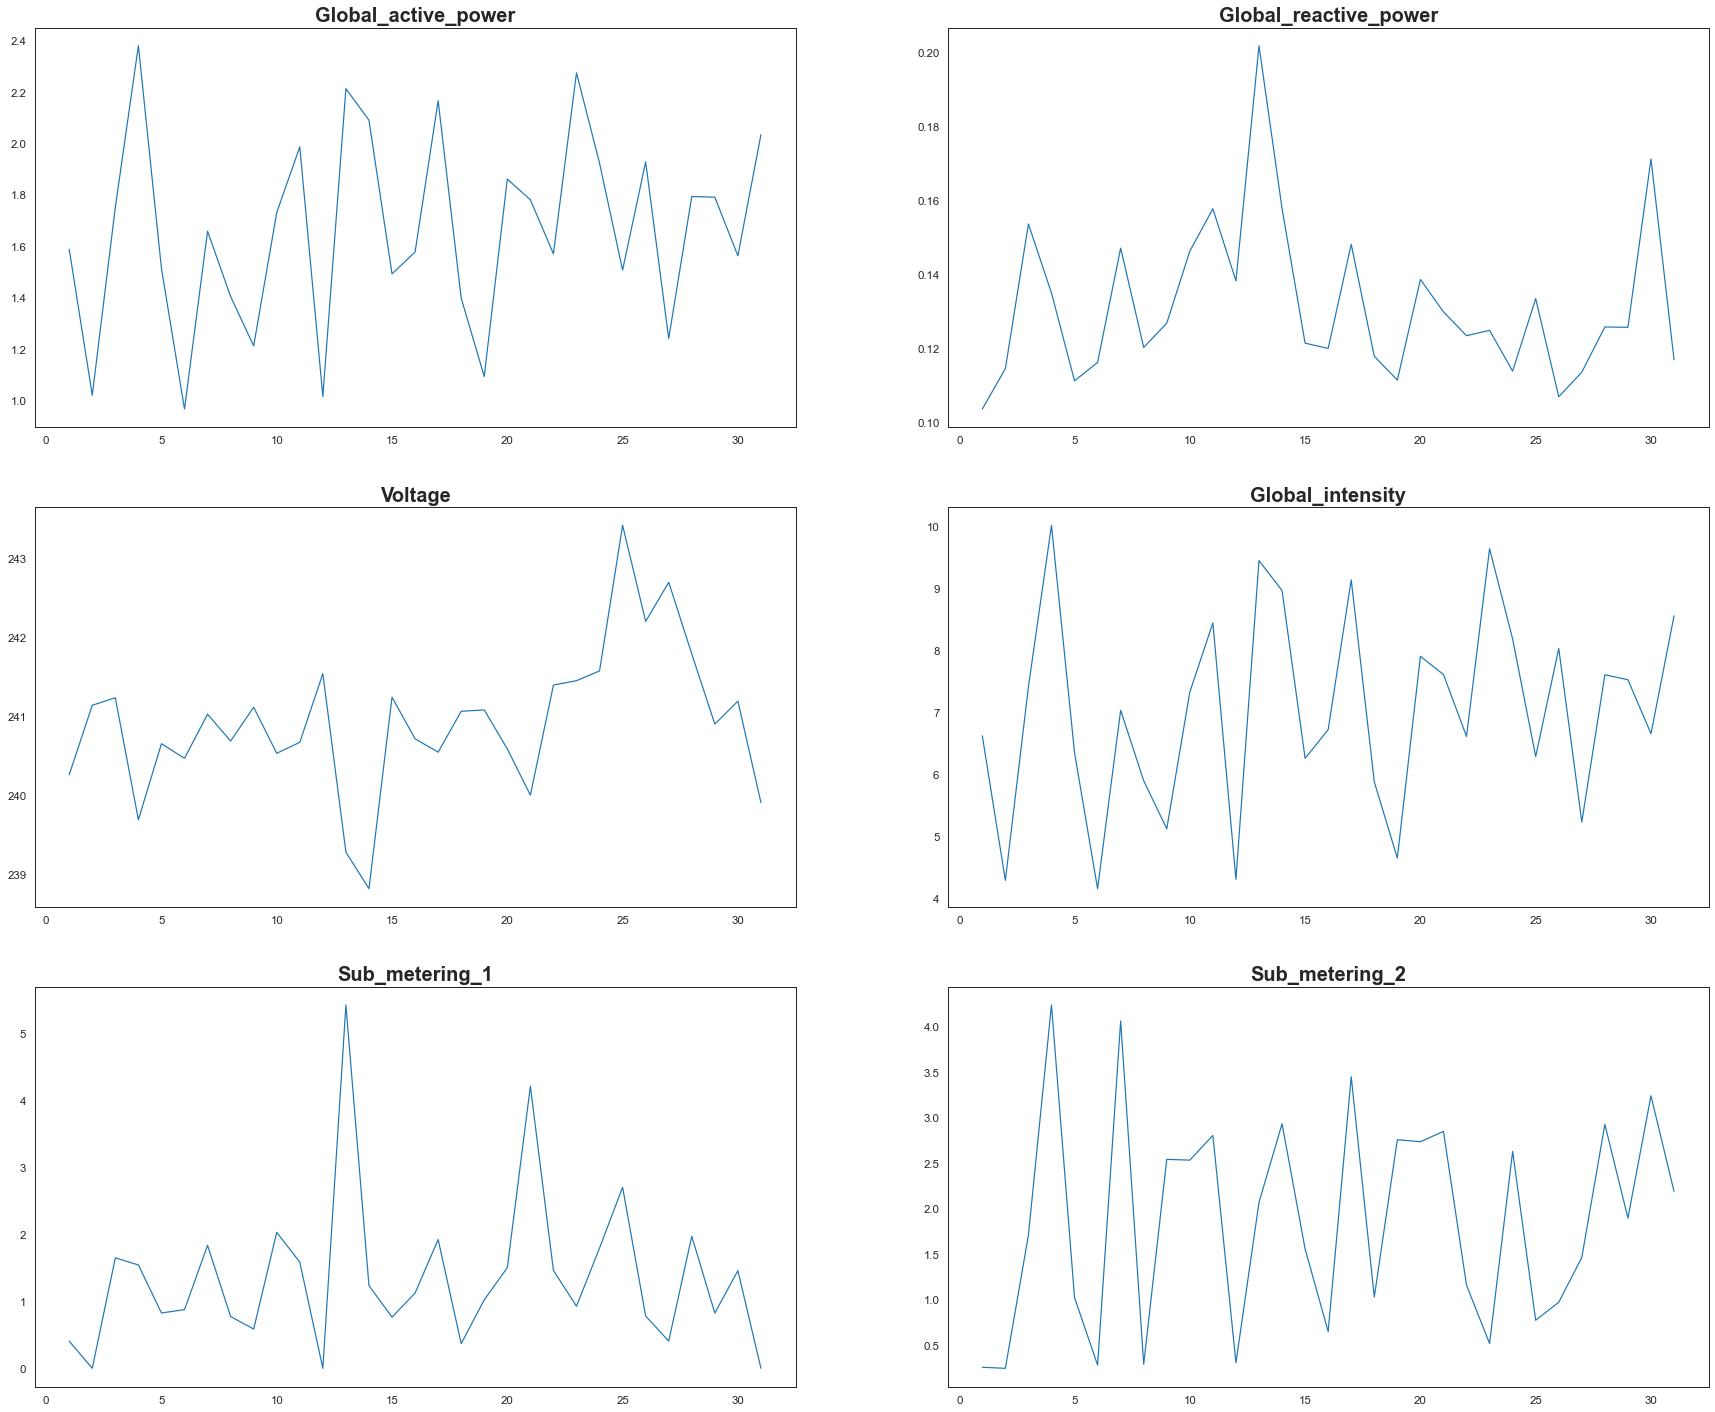

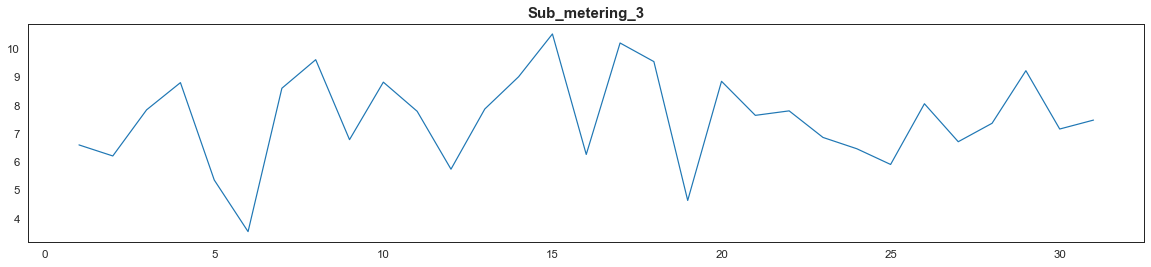

In [89]:
fig, axs = plt.subplots(3, 2, figsize = (30, 25))
columns = mean_consumption_gby_day_month.columns

axs[0, 0].plot(mean_consumption_gby_day_month[columns[0]])
axs[0, 0].set_title(columns[0], fontweight = 'bold', size = 20)

axs[0, 1].plot(mean_consumption_gby_day_month[columns[1]])
axs[0, 1].set_title(columns[1], fontweight = 'bold', size = 20)

axs[1, 0].plot(mean_consumption_gby_day_month[columns[2]])
axs[1, 0].set_title(columns[2], fontweight = 'bold', size = 20)

axs[1, 1].plot(mean_consumption_gby_day_month[columns[3]])
axs[1, 1].set_title(columns[3], fontweight = 'bold', size = 20)

axs[2, 0].plot(mean_consumption_gby_day_month[columns[4]])
axs[2, 0].set_title(columns[4], fontweight = 'bold', size = 20)

axs[2, 1].plot(mean_consumption_gby_day_month[columns[5]])
axs[2, 1].set_title(columns[5], fontweight = 'bold', size = 20)

fig, axs = plt.subplots( figsize = (20, 4))
axs.plot(mean_consumption_gby_day_month[columns[6]])
axs.set_title(columns[6], fontweight = 'bold', size = 15)

## Average consumption of each day in a week 

In [90]:
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
mean_consumption_gby_day_week = consumption_2.groupby(consumption_2.index.day_name()).mean().reindex(days)

Text(0.5, 1.0, 'Sub_metering_3')

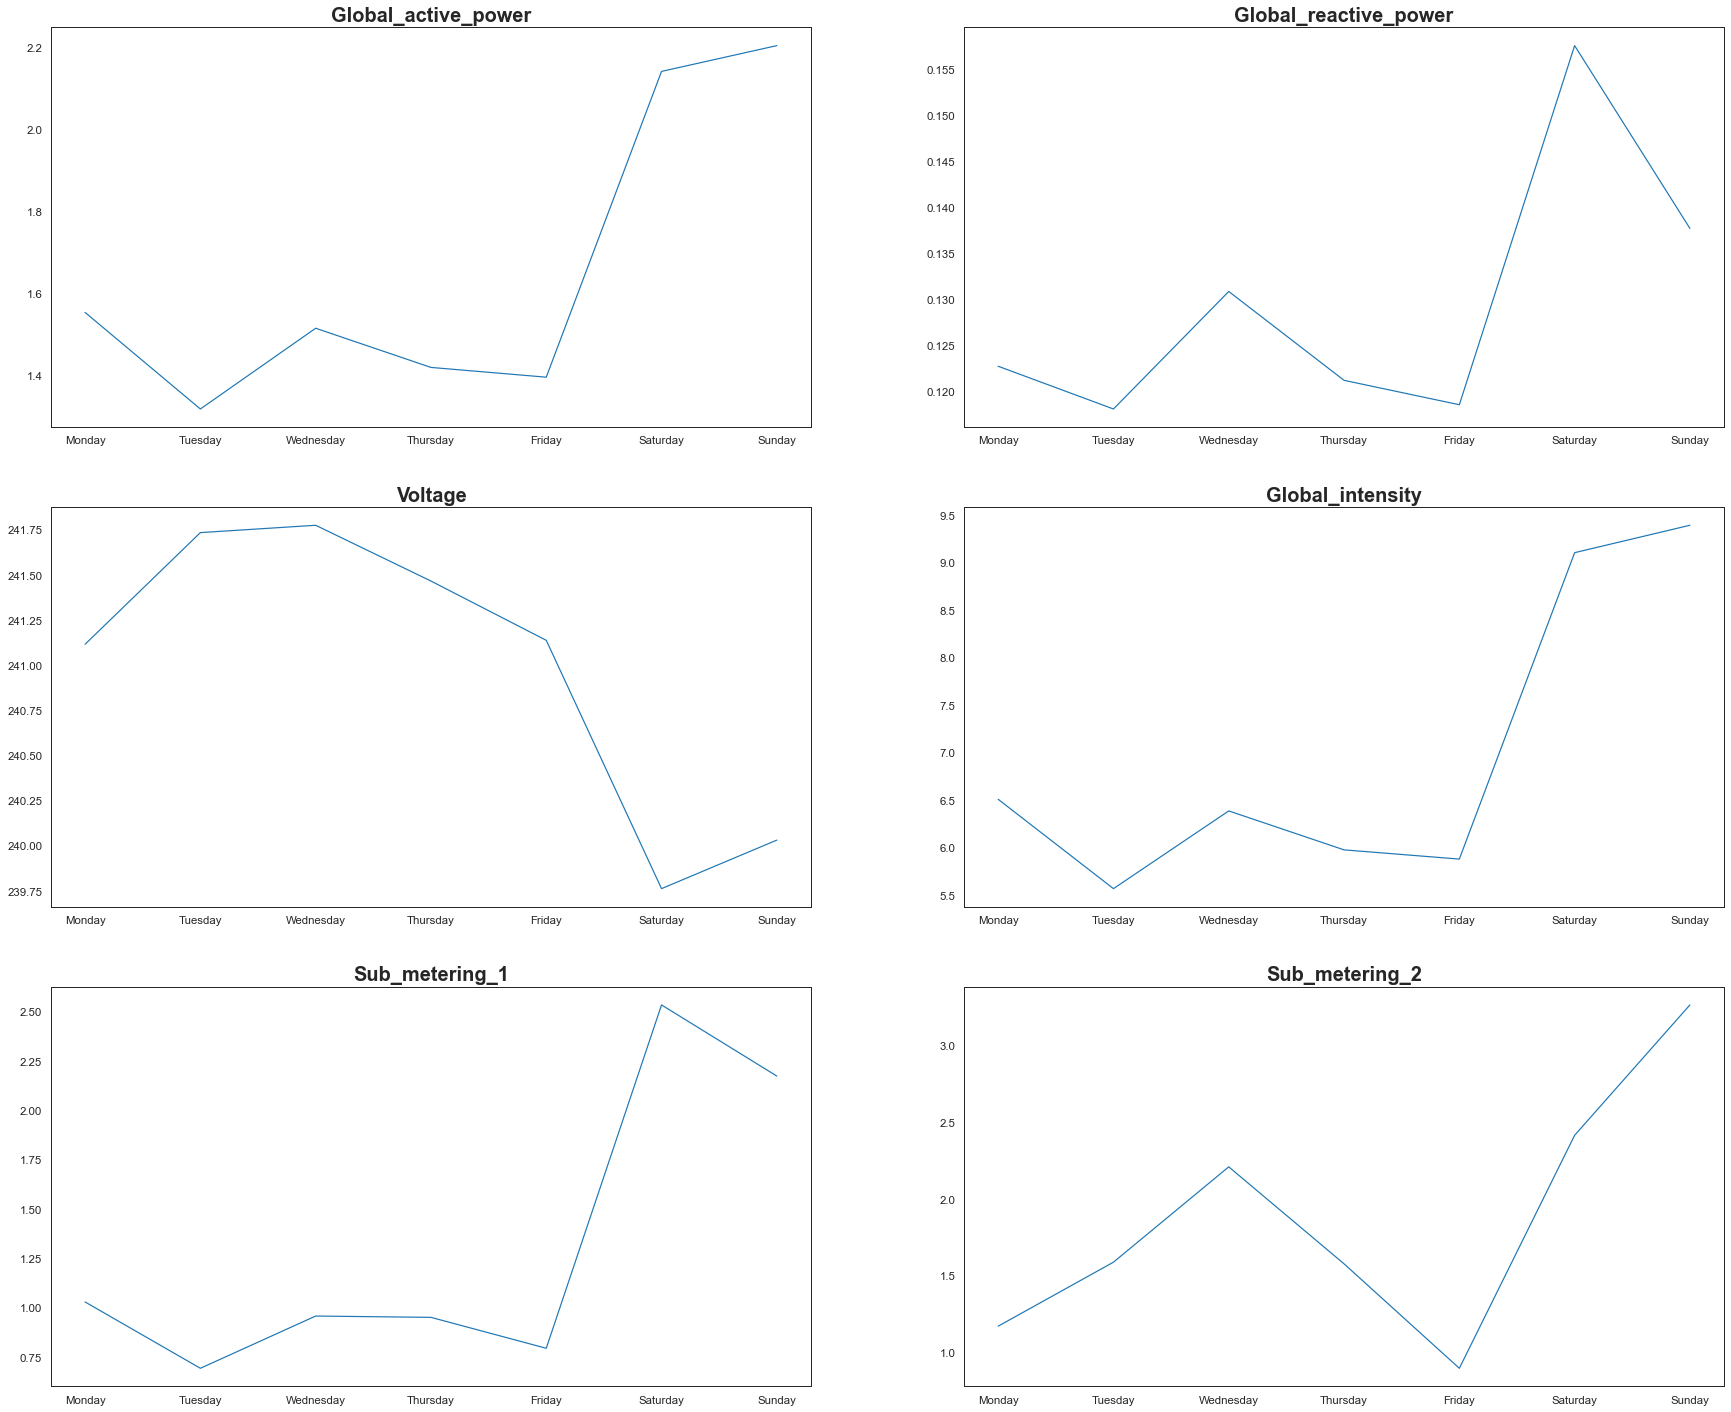

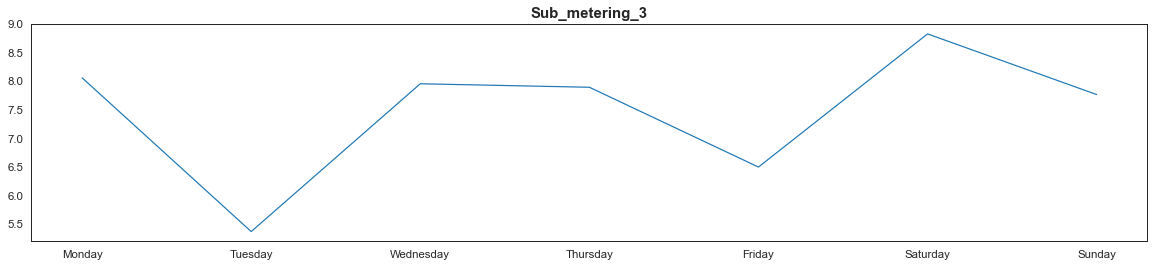

In [91]:
fig, axs = plt.subplots(3, 2, figsize = (30, 25))
columns = mean_consumption_gby_day_week.columns

axs[0, 0].plot(mean_consumption_gby_day_week[columns[0]])
axs[0, 0].set_title(columns[0], fontweight = 'bold', size = 20)

axs[0, 1].plot(mean_consumption_gby_day_week[columns[1]])
axs[0, 1].set_title(columns[1], fontweight = 'bold', size = 20)

axs[1, 0].plot(mean_consumption_gby_day_week[columns[2]])
axs[1, 0].set_title(columns[2], fontweight = 'bold', size = 20)

axs[1, 1].plot(mean_consumption_gby_day_week[columns[3]])
axs[1, 1].set_title(columns[3], fontweight = 'bold', size = 20)

axs[2, 0].plot(mean_consumption_gby_day_week[columns[4]])
axs[2, 0].set_title(columns[4], fontweight = 'bold', size = 20)

axs[2, 1].plot(mean_consumption_gby_day_week[columns[5]])
axs[2, 1].set_title(columns[5], fontweight = 'bold', size = 20)

fig, axs = plt.subplots( figsize = (20, 4))
axs.plot(mean_consumption_gby_day_week[columns[6]])
axs.set_title(columns[6], fontweight = 'bold', size = 15)

## Average consumption of each hour in a day

In [92]:
consumption_resampled_in_a_day = consumption_2.resample('H').sum()
consumption_resampled_in_a_day.index = consumption_resampled_in_a_day.index.time
mean_consumption_gby_time = consumption_resampled_in_a_day.groupby(consumption_resampled_in_a_day.index).mean()

Text(0.5, 1.0, 'Sub_metering_3')

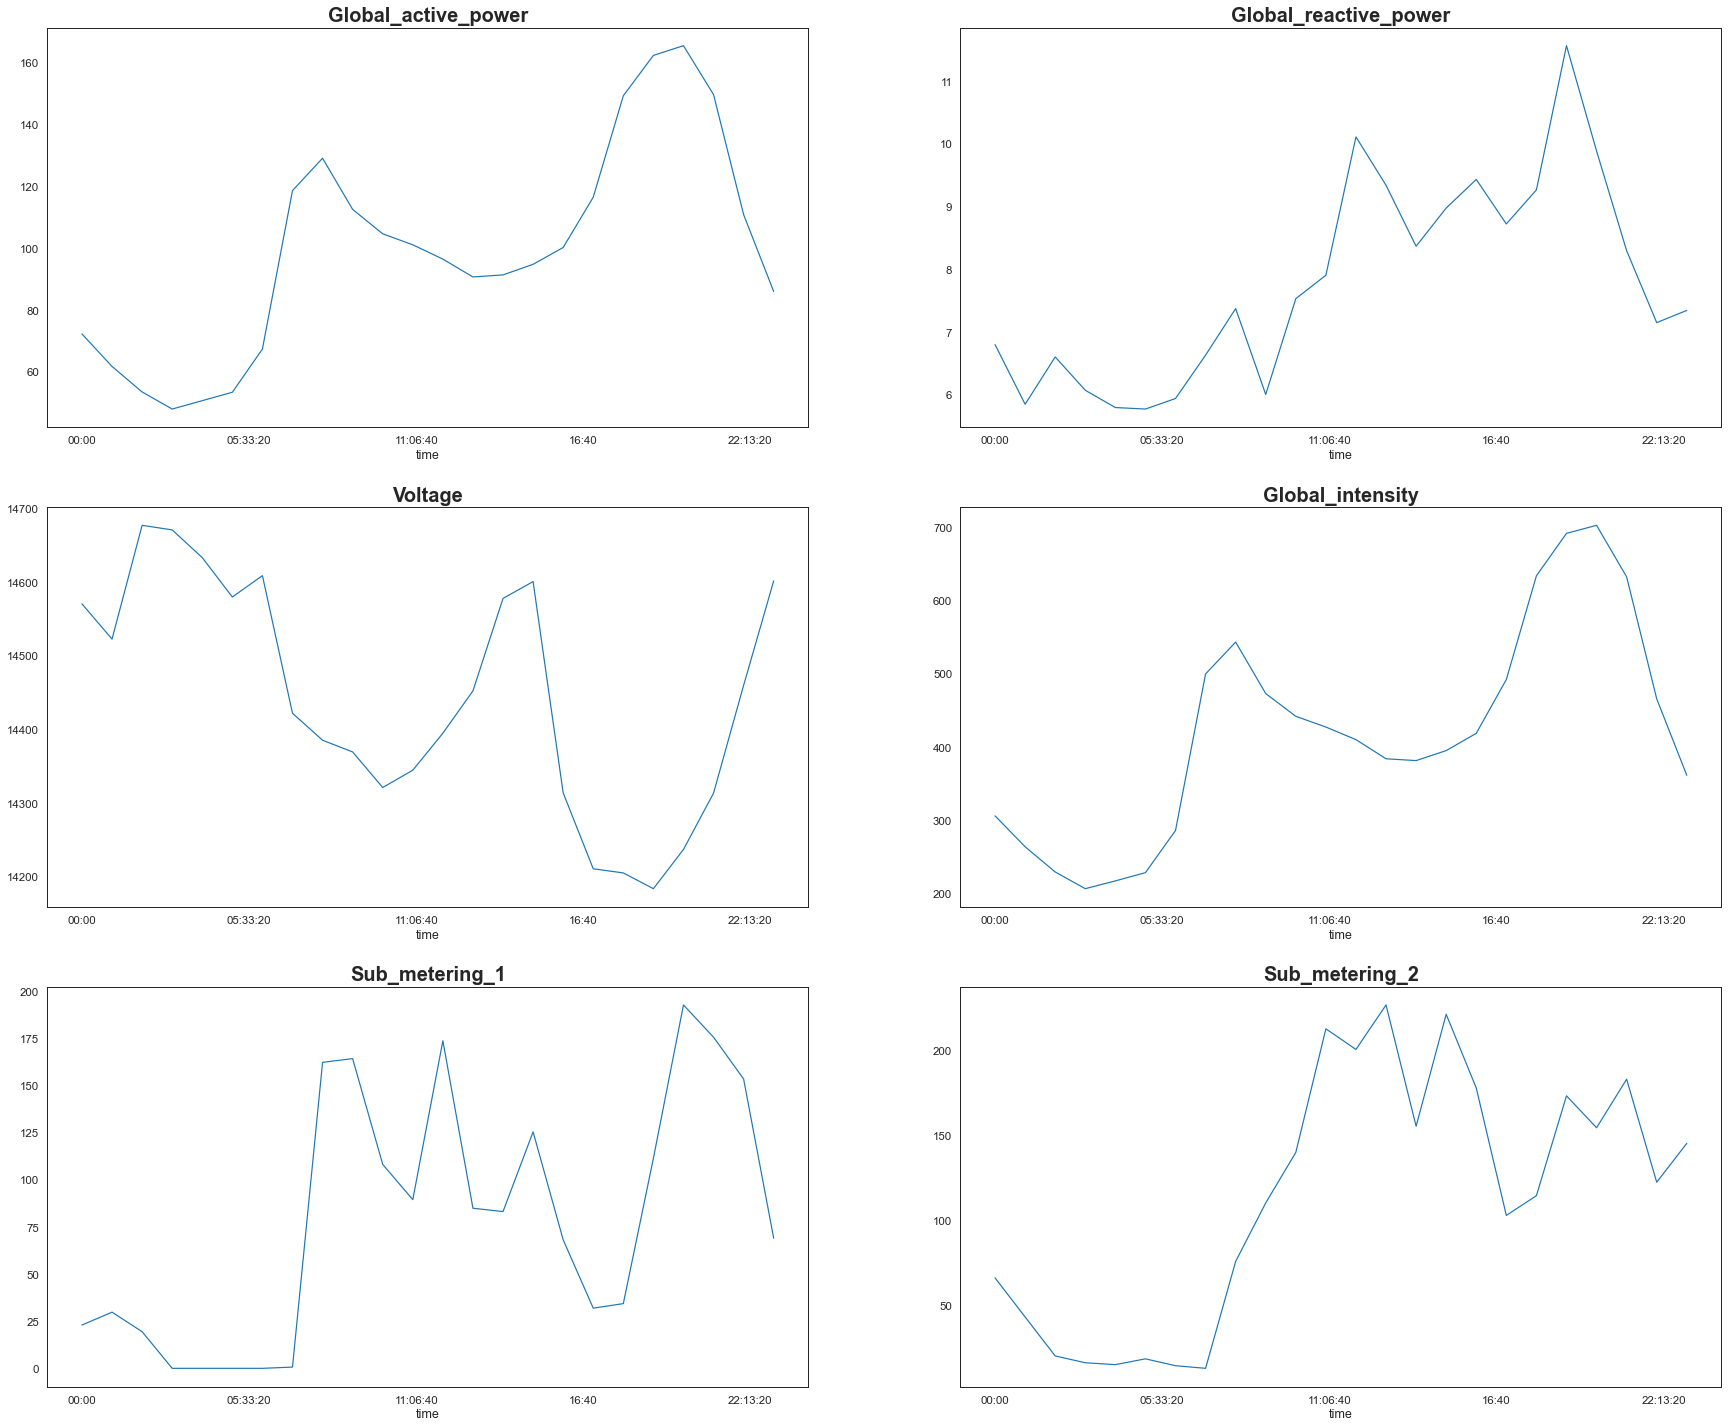

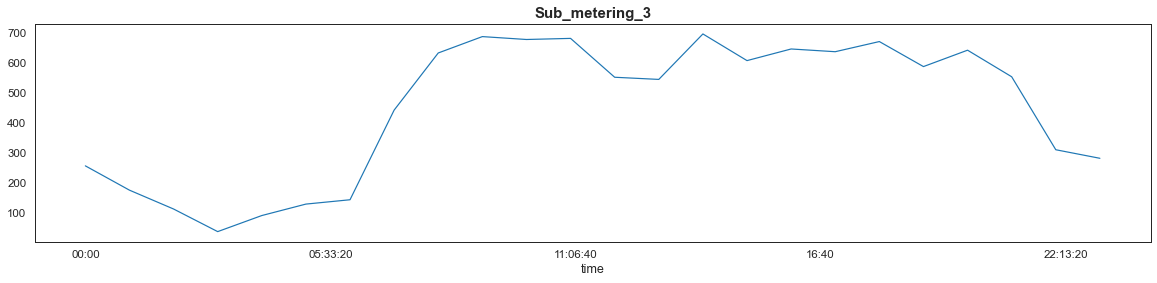

In [93]:
pd.plotting.register_matplotlib_converters()
fig, axs = plt.subplots(3, 2, figsize = (30, 25))
columns = mean_consumption_gby_time.columns

axs[0, 0].plot(mean_consumption_gby_time[columns[0]])
axs[0, 0].set_title(columns[0], fontweight = 'bold', size = 20)

axs[0, 1].plot(mean_consumption_gby_time[columns[1]])
axs[0, 1].set_title(columns[1], fontweight = 'bold', size = 20)

axs[1, 0].plot(mean_consumption_gby_time[columns[2]])
axs[1, 0].set_title(columns[2], fontweight = 'bold', size = 20)

axs[1, 1].plot(mean_consumption_gby_time[columns[3]])
axs[1, 1].set_title(columns[3], fontweight = 'bold', size = 20)

axs[2, 0].plot(mean_consumption_gby_time[columns[4]])
axs[2, 0].set_title(columns[4], fontweight = 'bold', size = 20)

axs[2, 1].plot(mean_consumption_gby_time[columns[5]])
axs[2, 1].set_title(columns[5], fontweight = 'bold', size = 20)

fig, axs = plt.subplots( figsize = (20, 4))
axs.plot(mean_consumption_gby_time[columns[6]])
axs.set_title(columns[6], fontweight = 'bold', size = 15)


In [94]:
mean_consumption_resampled_mnthly = consumption_2.resample('M').mean()

Text(0.5, 1.0, 'Sub_metering_3')

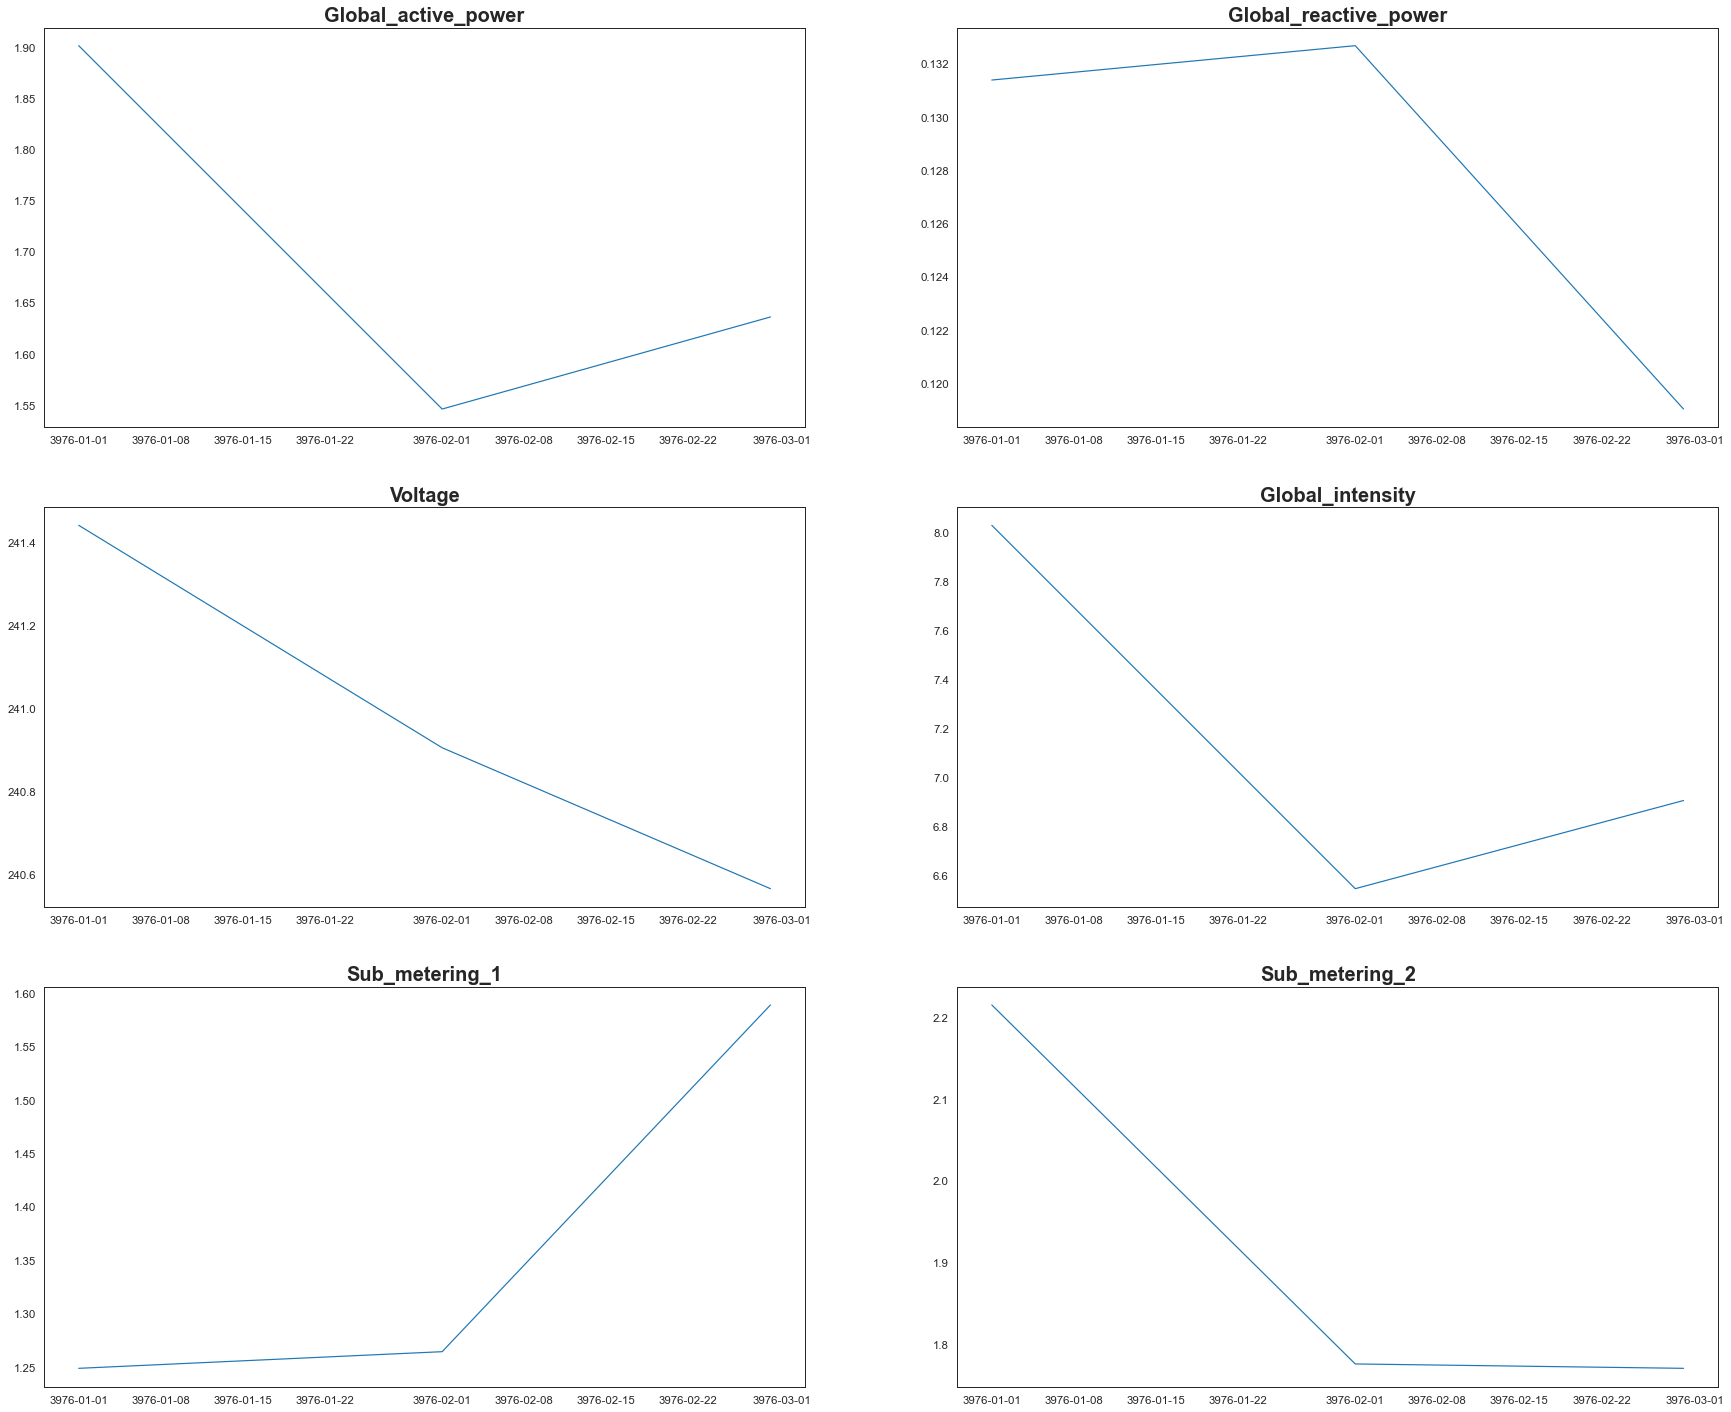

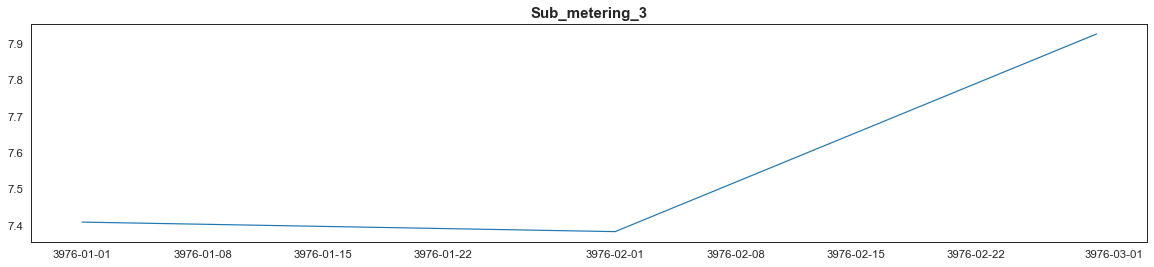

In [95]:
fig, axs = plt.subplots(3, 2, figsize = (30, 25))
columns = mean_consumption_resampled_mnthly.columns

axs[0, 0].plot(mean_consumption_resampled_mnthly[columns[0]])
axs[0, 0].set_title(columns[0], fontweight = 'bold', size = 20)

axs[0, 1].plot(mean_consumption_resampled_mnthly[columns[1]])
axs[0, 1].set_title(columns[1], fontweight = 'bold', size = 20)

axs[1, 0].plot(mean_consumption_resampled_mnthly[columns[2]])
axs[1, 0].set_title(columns[2], fontweight = 'bold', size = 20)

axs[1, 1].plot(mean_consumption_resampled_mnthly[columns[3]])
axs[1, 1].set_title(columns[3], fontweight = 'bold', size = 20)

axs[2, 0].plot(mean_consumption_resampled_mnthly[columns[4]])
axs[2, 0].set_title(columns[4], fontweight = 'bold', size = 20)

axs[2, 1].plot(mean_consumption_resampled_mnthly[columns[5]])
axs[2, 1].set_title(columns[5], fontweight = 'bold', size = 20)

fig, axs = plt.subplots( figsize = (20, 4))
axs.plot(mean_consumption_resampled_mnthly[columns[6]])
axs.set_title(columns[6], fontweight = 'bold', size = 15)

## VAR model

In [96]:
model = VAR(mean_consumption_resampled_mnthly)
model_fit = model.fit()
pred = model_fit.forecast(model_fit.y, steps=4)

In [97]:
del consumption 
del consumption_2 

data=pd.read_csv('household_power_consumption.txt', sep=';', nrows=82000, 
                 parse_dates={'date_time' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='date_time')

In [98]:
# count missing value
count=0
for i in data.isnull().sum(axis=1):
    if i>0:
        count=count+1
print('Total number of rows with missing values is ', count)
print('since it is only',round((count/len(data.index))*100), 'percent of the entire dataset the rows with missing values are excluded.')

Total number of rows with missing values is  6
since it is only 0 percent of the entire dataset the rows with missing values are excluded.


<AxesSubplot:>

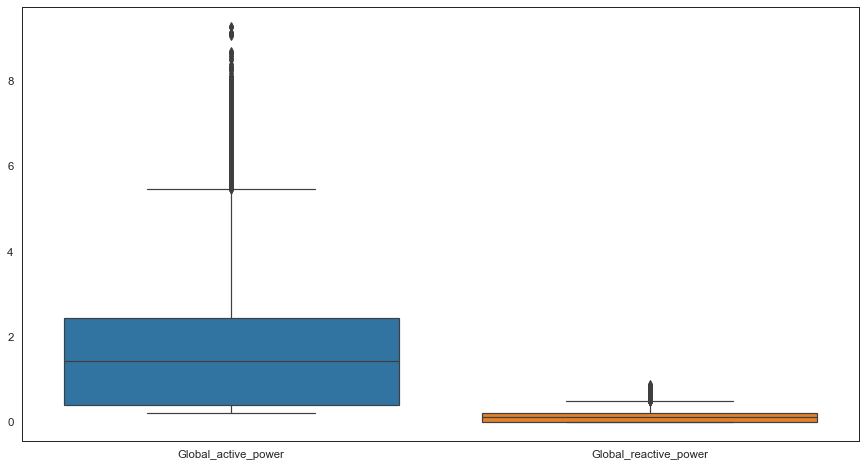

In [99]:
# plot boxplot for checking mean and median values for fill of null values . 
plt.figure(figsize=(15,8))
sns.boxplot(data=data.iloc[:,:2])

<AxesSubplot:>

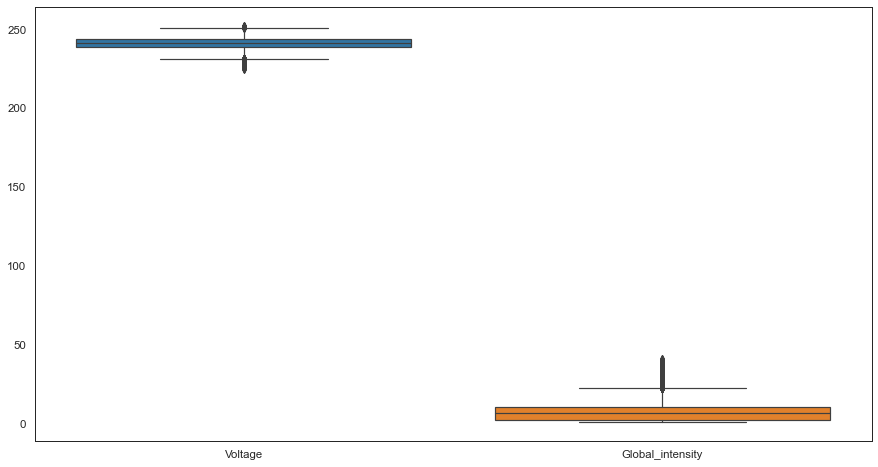

In [100]:
plt.figure(figsize=(15,8))
sns.boxplot(data=data.iloc[:,2:4])

<AxesSubplot:>

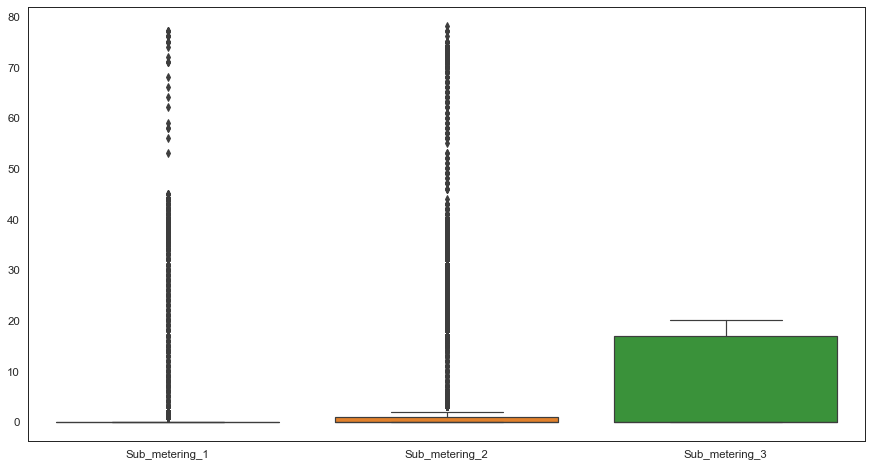

In [101]:
plt.figure(figsize=(15,8))
sns.boxplot(data=data.iloc[:,4:])

In [102]:
# fill nan with mean in column
for i in range(0,7):        
        data.iloc[:,i]=data.iloc[:,i].fillna(data.iloc[:,i].mean())

# Calculate power consumed per month 
1) Global_active_power
        
2) Global_reactive_power
       

# Global_active_power

In [103]:
# Sum of 'Global_active_power' resampled over month
data['Global_active_power'].resample('M').sum().head()

date_time
2006-12-31   41819.9147
2007-01-31   69015.1784
2007-02-28   25136.1760
Freq: M, Name: Global_active_power, dtype: float64

In [104]:
# mean of 'Global_active_power' resampled over month
data['Global_active_power'].resample('M').mean().head()

date_time
2006-12-31   1.9013
2007-01-31   1.5460
2007-02-28   1.6360
Freq: M, Name: Global_active_power, dtype: float64

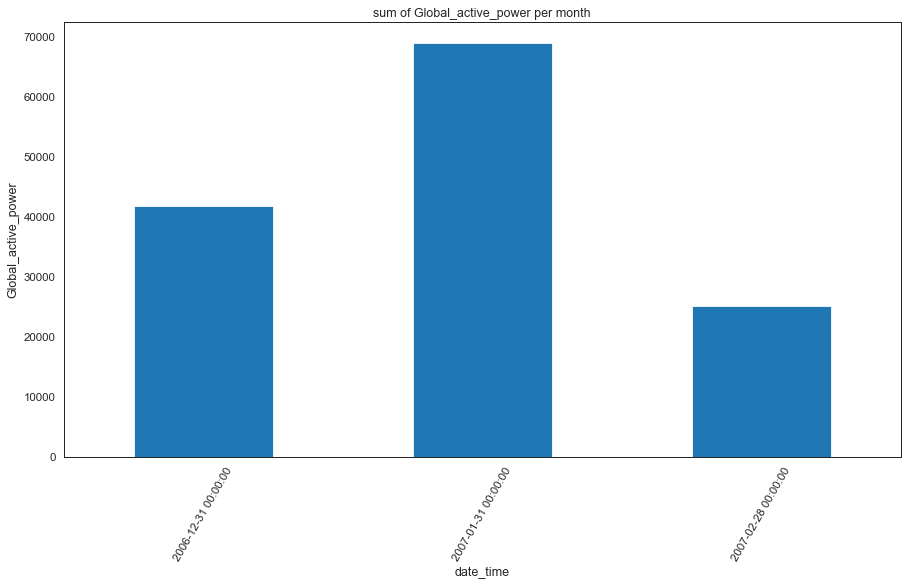

In [105]:
plt.figure(figsize=(15,8)) # size of plot
# Sum of 'Global_active_power' resampled over month
data['Global_active_power'].resample('M').sum().plot(kind='bar')
plt.xticks(rotation=60) #sequence Values to use for the xticks
plt.ylabel('Global_active_power')
plt.title('sum of Global_active_power per month')
plt.show()


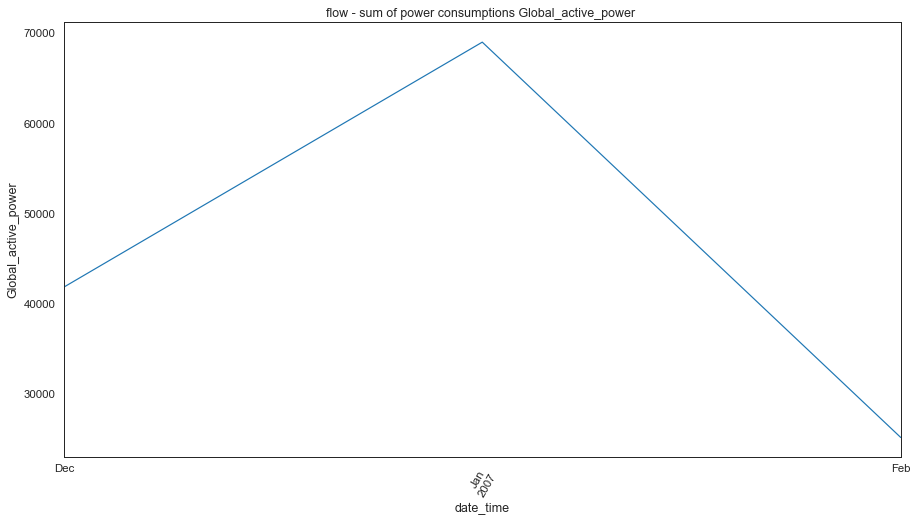

In [106]:
plt.figure(figsize=(15,8)) # size of plot
# Sum of 'Global_active_power' resampled over month
data['Global_active_power'].resample('M').sum().plot(kind='line')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('flow - sum of power consumptions Global_active_power ')
plt.show()

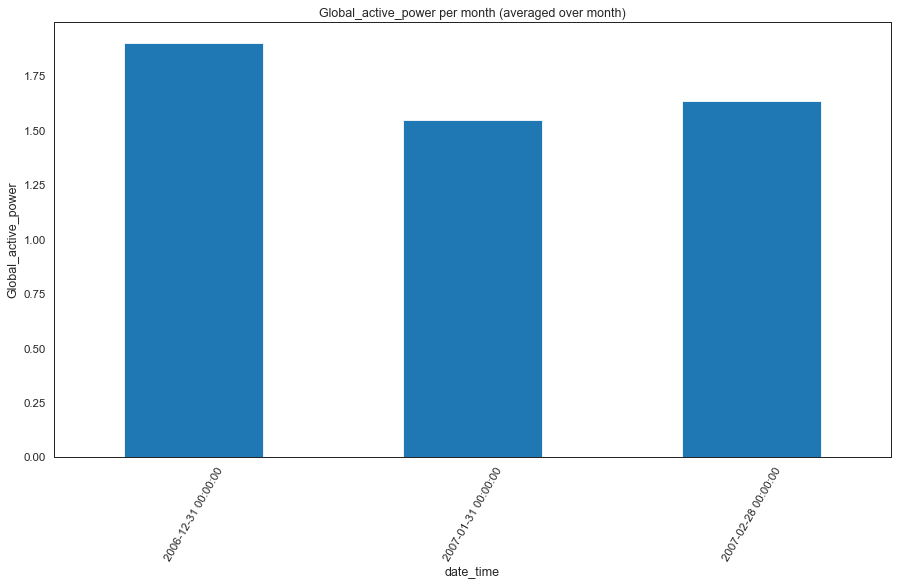

In [107]:
plt.figure(figsize=(15,8)) # size of plot
# Mean of 'Global_active_power' resampled over month
data['Global_active_power'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60) #sequence Values to use for the xticks
plt.ylabel('Global_active_power')
plt.title('Global_active_power per month (averaged over month)')
plt.show()

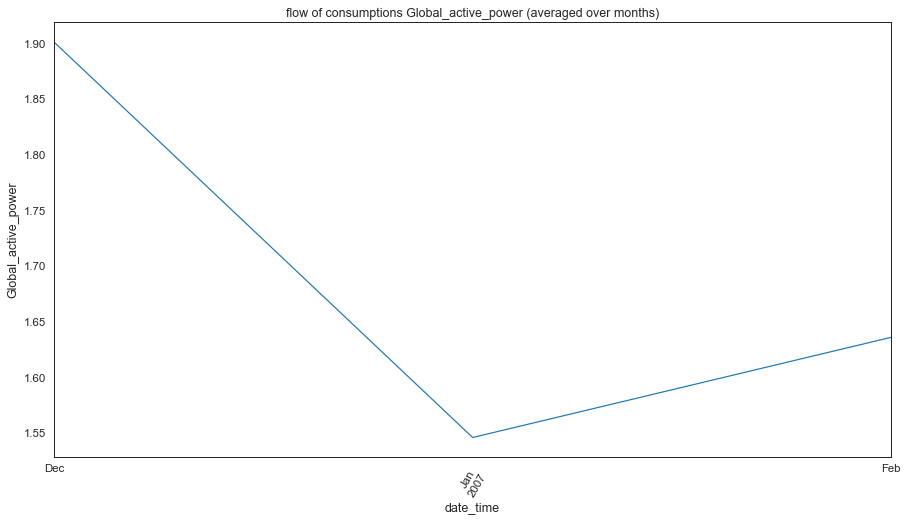

In [108]:
plt.figure(figsize=(15,8)) # size of plot
# mean of 'Global_active_power' resampled over month
data['Global_active_power'].resample('M').mean().plot(kind='line')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('flow of consumptions Global_active_power (averaged over months)')
plt.show()

# Global_reactive_power

In [109]:
# Sum of 'Global_reactive_power' resampled over month
data['Global_reactive_power'].resample('M').sum().head()

date_time
2006-12-31   2889.9551
2007-01-31   5922.6555
2007-02-28   1828.8300
Freq: M, Name: Global_reactive_power, dtype: float64

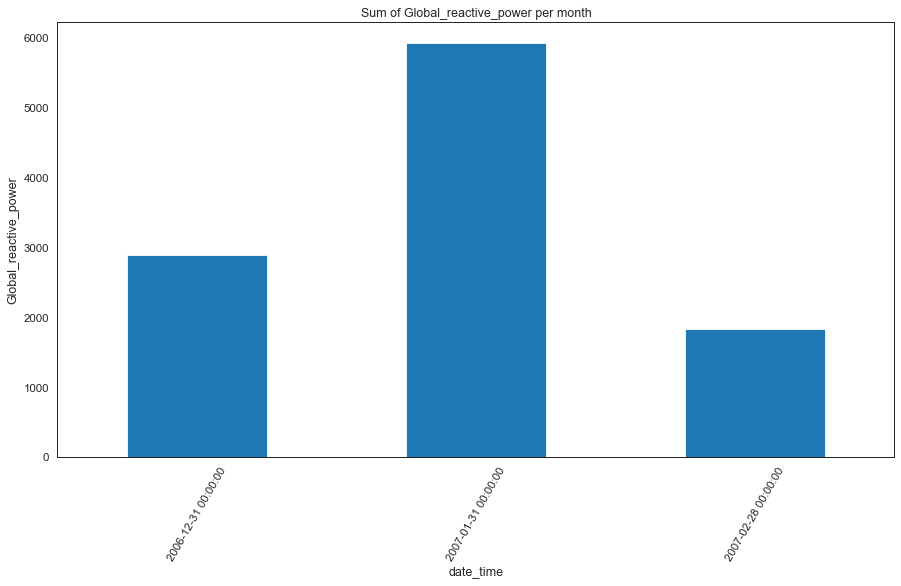

In [110]:
plt.figure(figsize=(15,8))
# Sum of 'Global_reactive_power' resampled over month
data['Global_reactive_power'].resample('M').sum().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_reactive_power')
plt.title('Sum of Global_reactive_power per month')
plt.show()

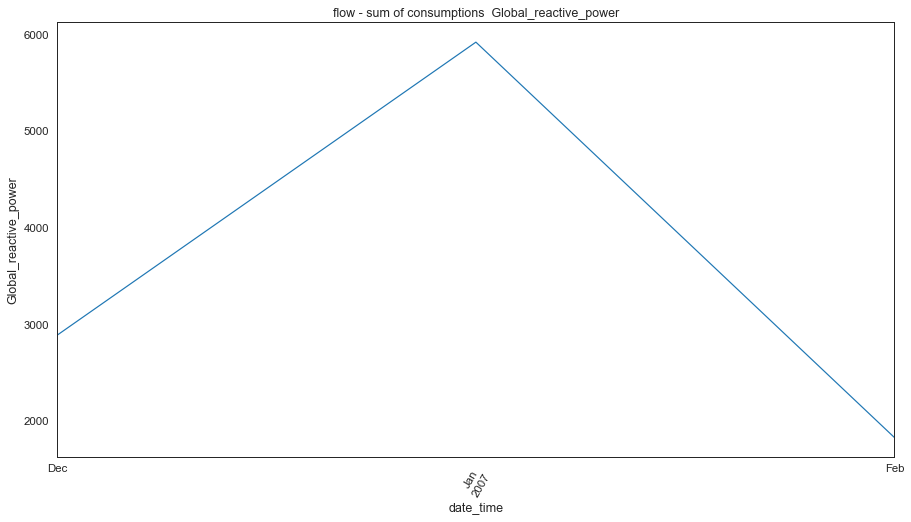

In [111]:
plt.figure(figsize=(15,8))
# Sum of 'Global_reactive_power' resampled over month
data['Global_reactive_power'].resample('M').sum().plot(kind='line')
plt.xticks(rotation=60)
plt.ylabel('Global_reactive_power')
plt.title('flow - sum of consumptions  Global_reactive_power')
plt.show()

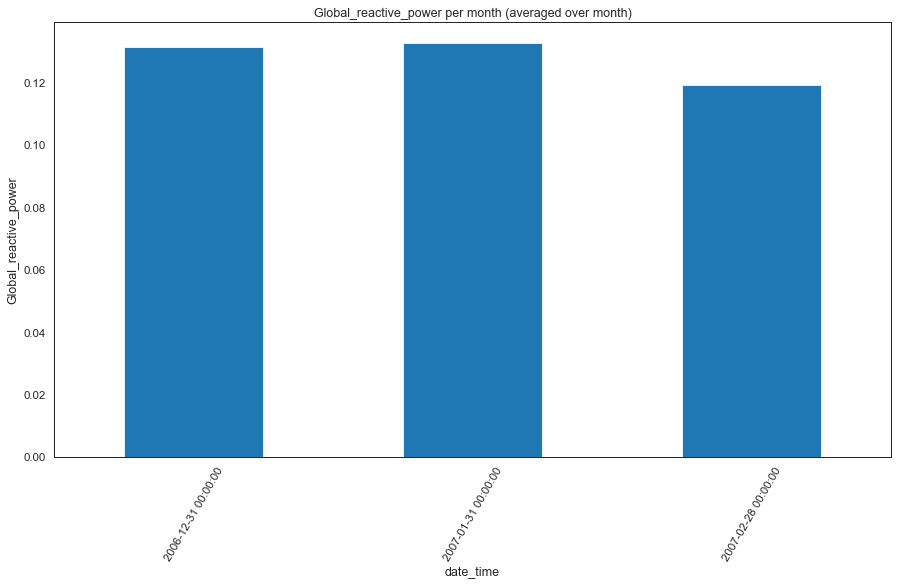

In [112]:
plt.figure(figsize=(15,8))
# mean of 'Global_reactive_power' resampled over month
data['Global_reactive_power'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_reactive_power')
plt.title('Global_reactive_power per month (averaged over month)')
plt.show()

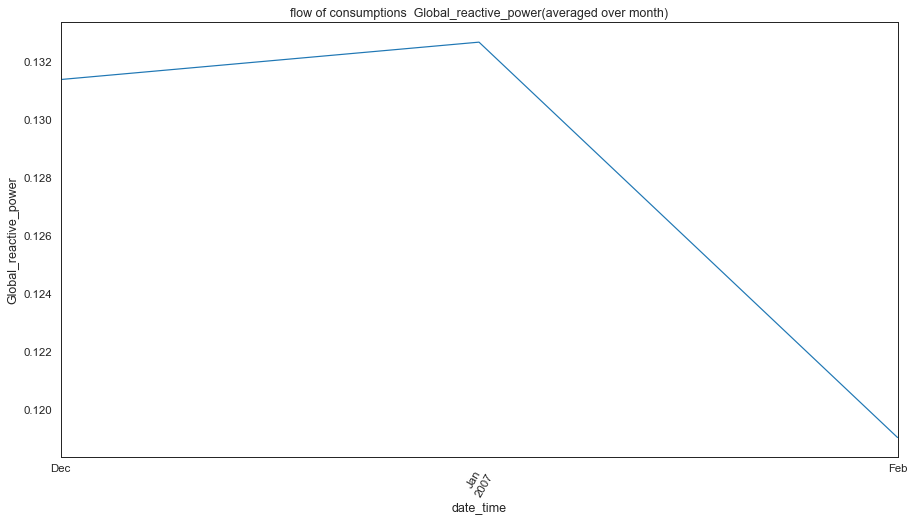

In [113]:
plt.figure(figsize=(15,8))
# mean of 'Global_reactive_power' resampled over month
data['Global_reactive_power'].resample('M').mean().plot(kind='line')
plt.xticks(rotation=60)
plt.ylabel('Global_reactive_power')
plt.title('flow of consumptions  Global_reactive_power(averaged over month)')
plt.show()

# Calculate power consumed by each sub=meter per month

1) Sub_metering_1

2) Sub_metering_2
 
3) Sub_metering_3

# Sub_metering_1

In [114]:
# Sum of 'Sub_metering_1' resampled over month
data['Sub_metering_1'].resample('M').sum().head()

date_time
2006-12-31   27465.2837
2007-01-31   56435.6418
2007-02-28   24414.0000
Freq: M, Name: Sub_metering_1, dtype: float64

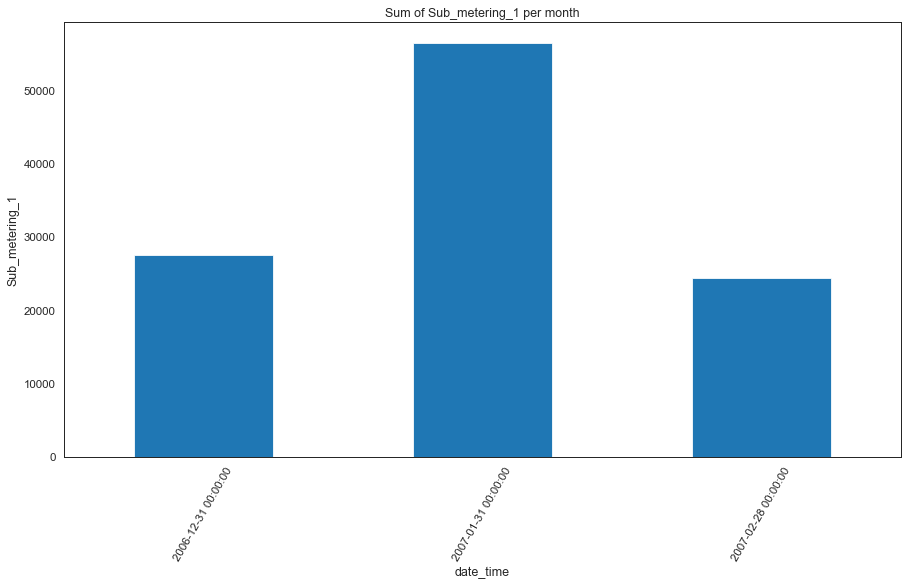

In [115]:
plt.figure(figsize=(15,8))
# Sum of 'Sub_metering_1' resampled over month
data['Sub_metering_1'].resample('M').sum().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_1')
plt.title('Sum of Sub_metering_1 per month')
plt.show()

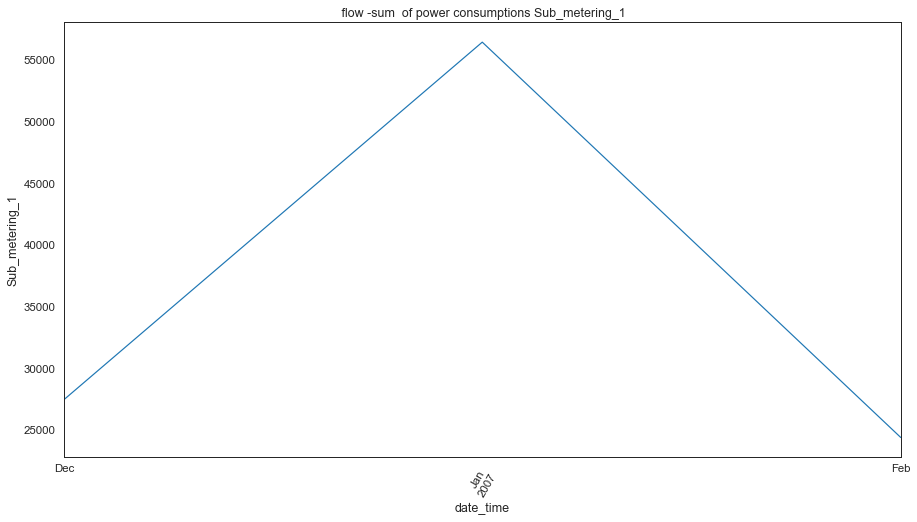

In [116]:
plt.figure(figsize=(15,8))
# Sum of 'Sub_metering_1' resampled over month
data['Sub_metering_1'].resample('M').sum().plot(kind='line')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_1')
plt.title(' flow -sum  of power consumptions Sub_metering_1')
plt.show()

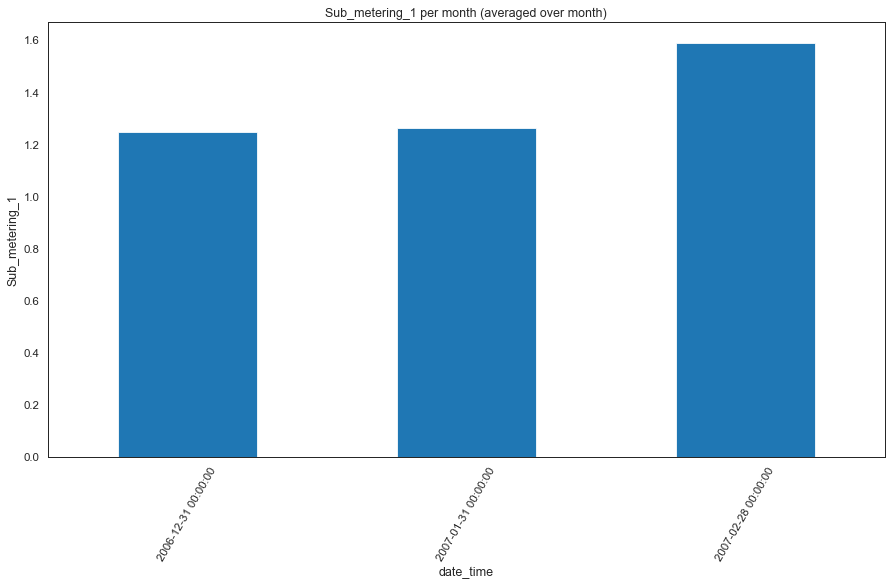

In [117]:
plt.figure(figsize=(15,8))
# mean of 'Sub_metering_1' resampled over month
data['Sub_metering_1'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_1')
plt.title('Sub_metering_1 per month (averaged over month)')
plt.show()

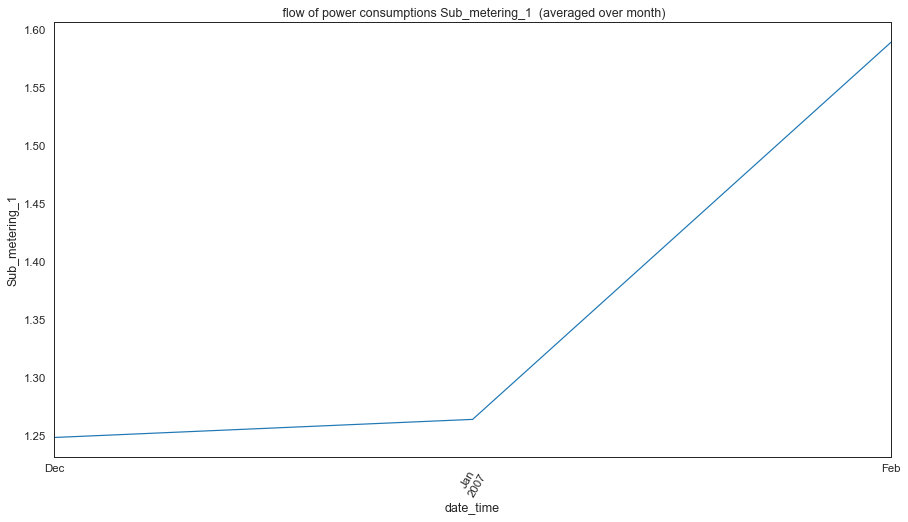

In [118]:
plt.figure(figsize=(15,8))
# mean of 'Sub_metering_1' resampled over month
data['Sub_metering_1'].resample('M').mean().plot(kind='line')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_1')
plt.title(' flow of power consumptions Sub_metering_1  (averaged over month)')
plt.show()

# Sub_metering_2

In [119]:
# Sum of 'Sub_metering_2' resampled over month
data['Sub_metering_2'].resample('M').sum().head()

date_time
2006-12-31   48719.5707
2007-01-31   79277.7854
2007-02-28   27203.0000
Freq: M, Name: Sub_metering_2, dtype: float64

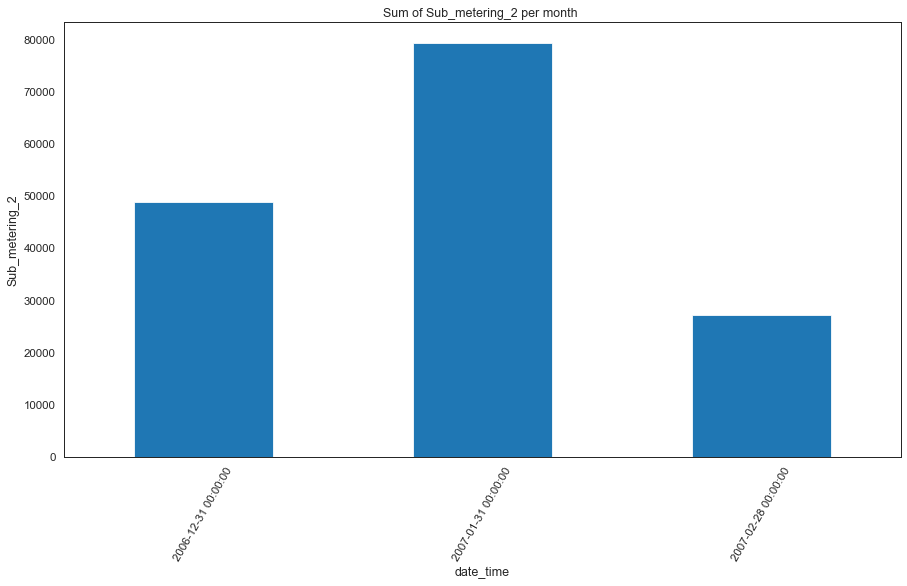

In [120]:
plt.figure(figsize=(15,8))
# Sum of 'Sub_metering_2' resampled over month
data['Sub_metering_2'].resample('M').sum().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_2')
plt.title('Sum of Sub_metering_2 per month ')
plt.show()


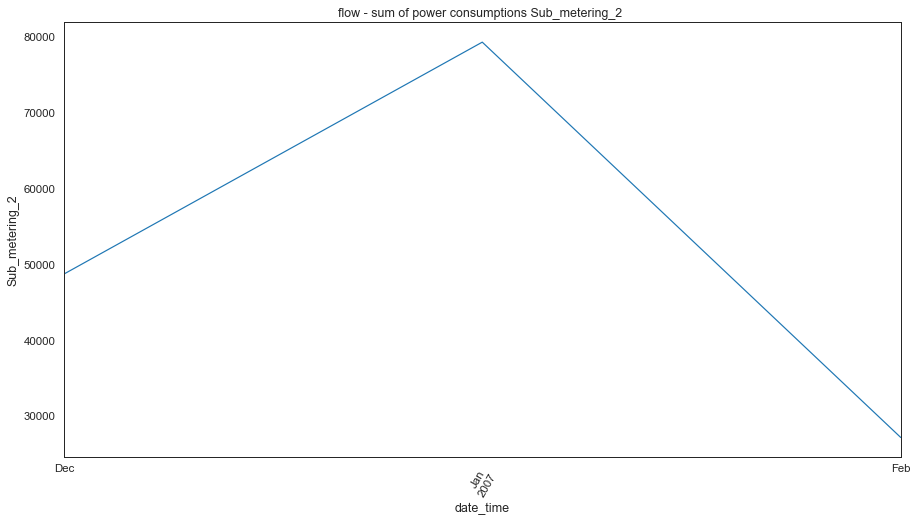

In [121]:
plt.figure(figsize=(15,8))
# Sum of 'Sub_metering_2' resampled over month
data['Sub_metering_2'].resample('M').sum().plot(kind='line')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_2')
plt.title('flow - sum of power consumptions Sub_metering_2 ')
plt.show()

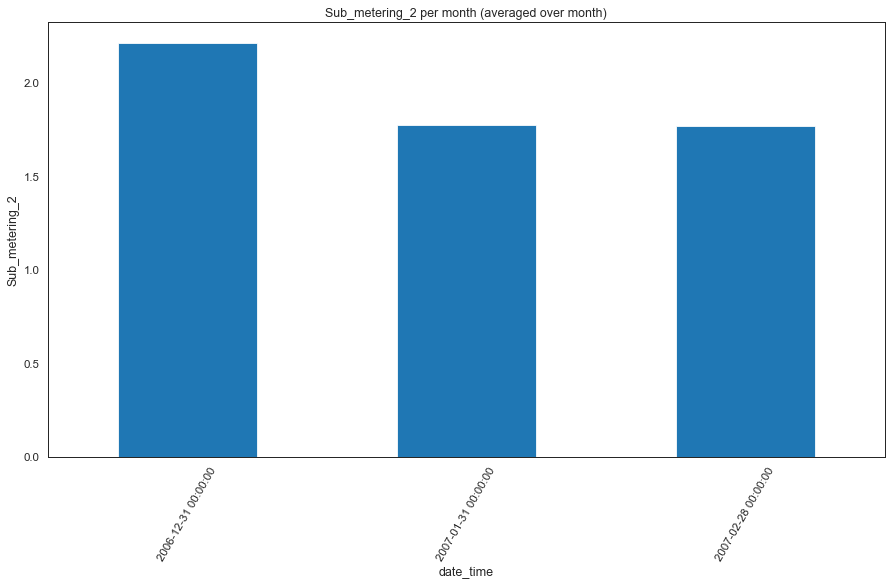

In [122]:
plt.figure(figsize=(15,8))
# mean of 'Sub_metering_2' resampled over month
data['Sub_metering_2'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_2')
plt.title('Sub_metering_2 per month (averaged over month)')
plt.show()

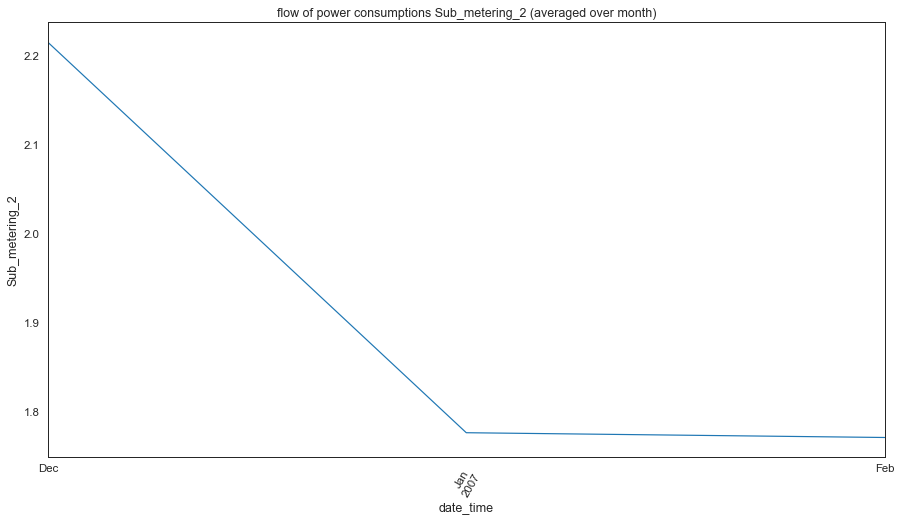

In [123]:
plt.figure(figsize=(15,8))
# mean of 'Sub_metering_2' resampled over month
data['Sub_metering_2'].resample('M').mean().plot(kind='line')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_2')
plt.title('flow of power consumptions Sub_metering_2 (averaged over month)')
plt.show()

 # Sub_metering_3

In [124]:
# Sum of 'Sub_metering_3' resampled over month
data['Sub_metering_3'].resample('M').sum().head()

date_time
2006-12-31   162980.9693
2007-01-31   329592.9847
2007-02-28   121797.0000
Freq: M, Name: Sub_metering_3, dtype: float64

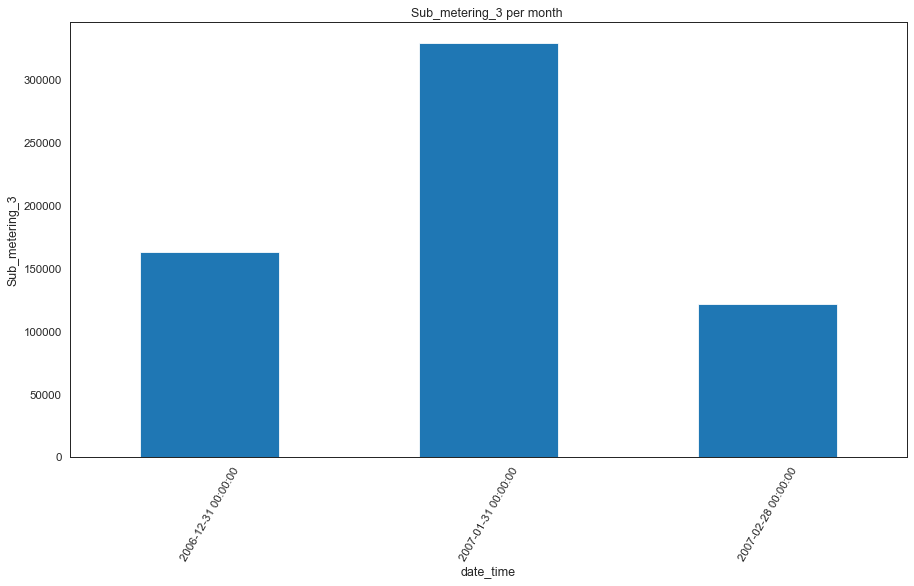

In [125]:
plt.figure(figsize=(15,8))
# Sum of 'Sub_metering_3' resampled over month
data['Sub_metering_3'].resample('M').sum().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_3')
plt.title('Sub_metering_3 per month ')
plt.show()

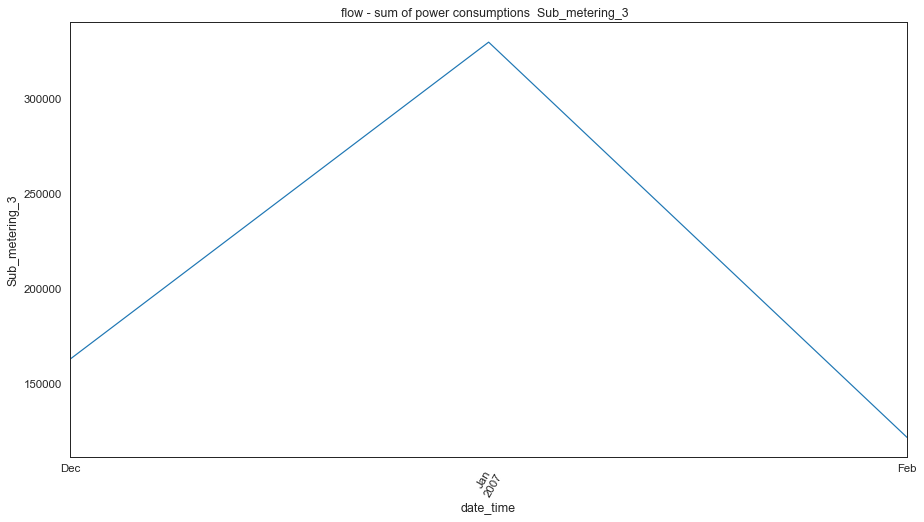

In [126]:
plt.figure(figsize=(15,8))
# Sum of 'Sub_metering_3' resampled over month
data['Sub_metering_3'].resample('M').sum().plot(kind='line')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_3')
plt.title('flow - sum of power consumptions  Sub_metering_3  ')
plt.show()

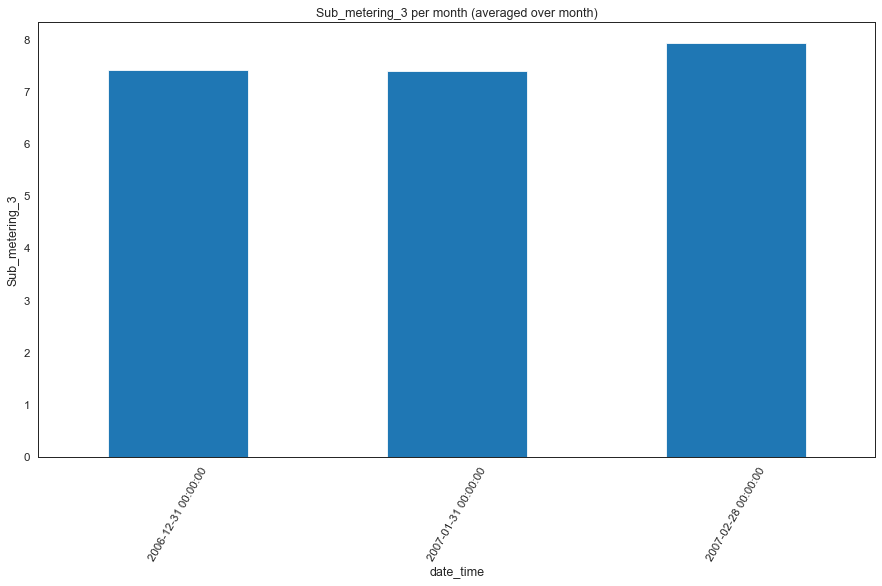

In [127]:
plt.figure(figsize=(15,8))
# mean of 'Sub_metering_3' resampled over month
data['Sub_metering_3'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_3')
plt.title('Sub_metering_3 per month (averaged over month)')
plt.show()

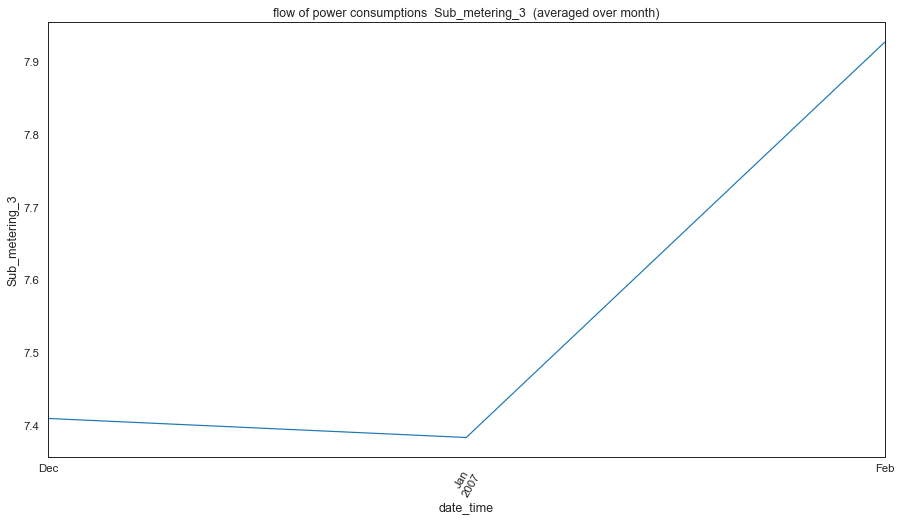

In [128]:
plt.figure(figsize=(15,8))
# Sum of 'Sub_metering_3' resampled over month
data['Sub_metering_3'].resample('M').mean().plot(kind='line')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_3')
plt.title('flow of power consumptions  Sub_metering_3  (averaged over month)')
plt.show()

In [129]:
del data 


df = pd.read_csv('household_power_consumption.txt', sep=';', nrows=82000, 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')
df.dropna(how = 'any', inplace = True) #dropped the 1% of measurements

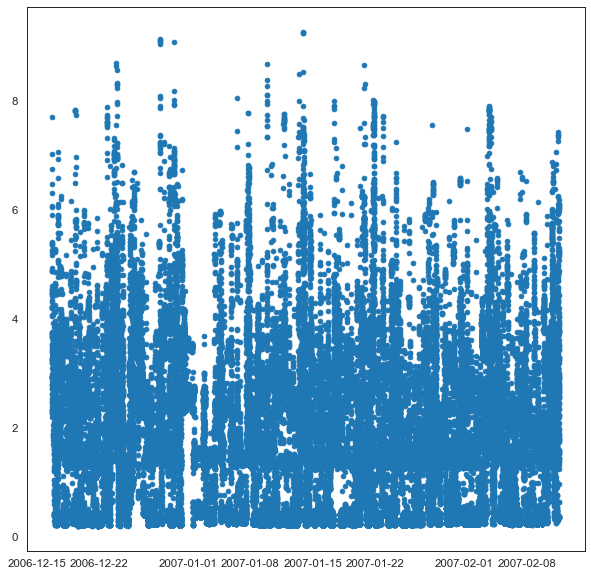

In [130]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.scatter(df.index, df['Global_active_power'])

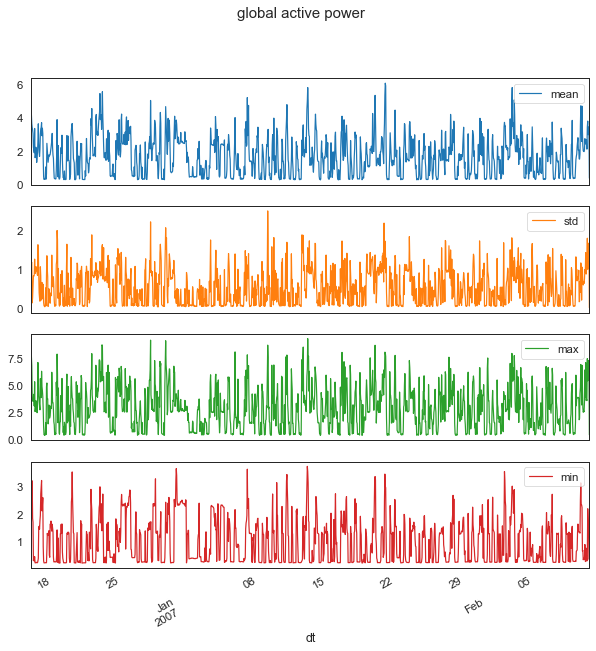

In [131]:
r = df.Global_active_power.resample('h').agg(['mean','std','max','min'])
r.plot(subplots = True, title='global active power')
plt.show()

- *resample over 30 minutes*
- *if you want to resample over 1 hour use the script below*

```python
# resampling of data over 1 hour
df_resample = df.resample('h').mean() 
df_resample.shape
```


In [132]:
## resampling of data over 30 minutes
df_resample = df.resample('30Min').mean() 
df_resample.shape

(2735, 7)

In [133]:
df_resample = df_resample.drop('Global_reactive_power',1)
df_resample = df_resample.drop('Global_intensity',1)

In [134]:
df_resample

Global_active_power  Voltage  Sub_metering_1  \
dt                                                                  
2006-12-16 17:00:00               4.5873 234.3667          0.0000   
2006-12-16 17:30:00               4.1500 234.6993          0.0000   
2006-12-16 18:00:00               3.9448 235.1847          0.0000   
2006-12-16 18:30:00               3.3196 233.9757          0.0000   
2006-12-16 19:00:00               3.4644 233.7540          0.0000   
...                                  ...      ...             ...   
2007-02-11 14:00:00               3.8917 239.5823          7.5667   
2007-02-11 14:30:00               2.9705 240.5957         10.0000   
2007-02-11 15:00:00               3.8689 240.2723          1.2333   
2007-02-11 15:30:00               2.0000 241.7200         18.5000   
2007-02-11 16:00:00               0.3515 241.3250          0.0000   

                     Sub_metering_2  Sub_metering_3  
dt                                                   
2006-12-16 17:00:00          1.3333         16.8333  
2006-12-16 17:30:00          0.3667         16.8667  
2006-12-16 18:00:00         11.4000         16.9667  
2006-12-16 18:30:00          2.0333         16.7667  
2006-12-16 19:00:00          1.8333         16.7667  
...                             ...             ...  
2007-02-11 14:00:00         33.0667         17.6000  
2007-02-11 14:30:00         14.1667         17.7333  
2007-02-11 15:00:00         38.8667         13.4000  
2007-02-11 15:30:00          8.6000          0.0000  
2007-02-11 16:00:00          0.2500          0.0000  

[2735 rows x 5 columns]

Train on 1100 samples, validate on 267 samples
Epoch 1/100
 - 2s - loss: 0.0549 - val_loss: 0.0301
Epoch 2/100
 - 0s - loss: 0.0285 - val_loss: 0.0257
Epoch 3/100
 - 0s - loss: 0.0252 - val_loss: 0.0234
Epoch 4/100
 - 0s - loss: 0.0231 - val_loss: 0.0220
Epoch 5/100
 - 0s - loss: 0.0223 - val_loss: 0.0210
Epoch 6/100
 - 0s - loss: 0.0209 - val_loss: 0.0202
Epoch 7/100
 - 0s - loss: 0.0195 - val_loss: 0.0193
Epoch 8/100
 - 0s - loss: 0.0185 - val_loss: 0.0186
Epoch 9/100
 - 0s - loss: 0.0181 - val_loss: 0.0179
Epoch 10/100
 - 0s - loss: 0.0175 - val_loss: 0.0173
Epoch 11/100
 - 0s - loss: 0.0166 - val_loss: 0.0169
Epoch 12/100
 - 0s - loss: 0.0166 - val_loss: 0.0165
Epoch 13/100
 - 0s - loss: 0.0159 - val_loss: 0.0161
Epoch 14/100
 - 0s - loss: 0.0156 - val_loss: 0.0159
Epoch 15/100
 - 0s - loss: 0.0157 - val_loss: 0.0158
Epoch 16/100
 - 0s - loss: 0.0154 - val_loss: 0.0156
Epoch 17/100
 - 0s - loss: 0.0153 - val_loss: 0.0155
Epoch 18/100
 - 0s - loss: 0.0154 - val_loss: 0.0154
Epoch 19

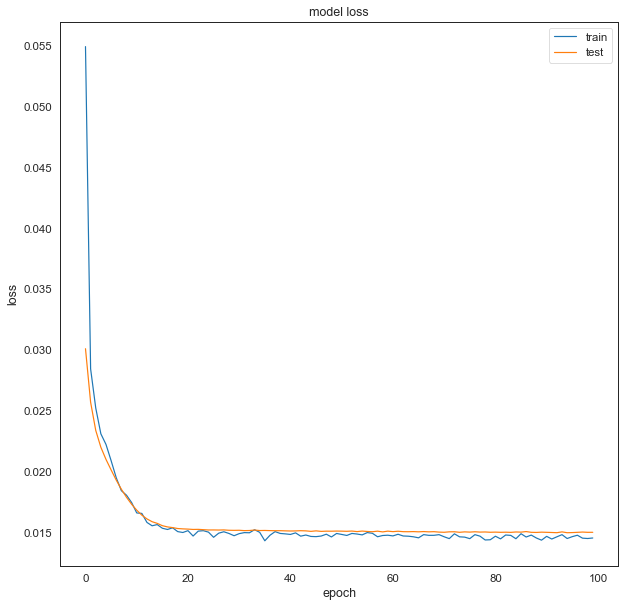

[[0.26179278]
 [0.2549034 ]
 [0.35376257]
 [0.22513175]
 [0.23760554]
 [0.44890535]
 [0.36047924]
 [0.19437861]
 [0.42815518]
 [0.27807117]
 [0.05015032]
 [0.04540648]
 [0.0576816 ]
 [0.04712651]
 [0.04513626]
 [0.05330578]
 [0.1020839 ]
 [0.32507   ]
 [0.42681116]
 [0.437712  ]
 [0.25040996]
 [0.20108372]
 [0.20045042]
 [0.10159345]
 [0.05771513]
 [0.05893105]
 [0.05235464]
 [0.06031498]
 [0.13818517]
 [0.38778508]
 [0.44554293]
 [0.32288468]
 [0.21887192]
 [0.21840152]
 [0.18455172]
 [0.1152869 ]
 [0.05402744]
 [0.04424818]
 [0.05261613]
 [0.04817077]
 [0.04254887]
 [0.20373222]
 [0.31772596]
 [0.22206292]
 [0.2129415 ]
 [0.24717587]
 [0.19365346]
 [0.1245508 ]
 [0.22184405]
 [0.12701043]
 [0.05241931]
 [0.07617503]
 [0.08972554]
 [0.32984632]
 [0.30974412]
 [0.17908975]
 [0.10870899]
 [0.3441407 ]
 [0.4801067 ]
 [0.51402885]
 [0.4913502 ]
 [0.49205357]
 [0.37160367]
 [0.34550172]
 [0.3777683 ]
 [0.33077398]
 [0.33100677]
 [0.3535141 ]
 [0.22029626]
 [0.23085144]
 [0.22779468]
 [0.22

In [135]:
values = reframed.values
n_train_time = 1100 
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_X, train_y, epochs=100, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
yhat = model.predict(test_X)
print(yhat)

In [136]:
del df
dataset = pd.read_csv("household_power_consumption.txt", sep=';', nrows=82000, header=0, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [137]:
print(f"The Dataset has {dataset.shape[0]} rows and {dataset.shape[1]} columns")

The Dataset has 82000 rows and 7 columns


In [138]:
percent_missing = dataset.isnull().sum() * 100 / len(dataset)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})

In [139]:
missing_value_df

percent_missing
Global_active_power             0.0000
Global_reactive_power           0.0000
Voltage                         0.0000
Global_intensity                0.0000
Sub_metering_1                  0.0000
Sub_metering_2                  0.0000
Sub_metering_3                  0.0073

In [140]:
dataset1 = dataset.dropna(how = 'any')

In [141]:
dataset1.shape

(81994, 7)

In [142]:
dataset.loc[dataset.Sub_metering_3.isnull()].head()

Global_active_power Global_reactive_power Voltage  \
datetime                                                                
2006-12-21 11:23:00                   ?                     ?       ?   
2006-12-21 11:24:00                   ?                     ?       ?   
2006-12-30 10:08:00                   ?                     ?       ?   
2006-12-30 10:09:00                   ?                     ?       ?   
2007-01-14 18:36:00                   ?                     ?       ?   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
datetime                                                             
2006-12-21 11:23:00                ?              ?              ?   
2006-12-21 11:24:00                ?              ?              ?   
2006-12-30 10:08:00                ?              ?              ?   
2006-12-30 10:09:00                ?              ?              ?   
2007-01-14 18:36:00                ?              ?              ?   

                     Sub_metering_3  
datetime                             
2006-12-21 11:23:00             nan  
2006-12-21 11:24:00             nan  
2006-12-30 10:08:00             nan  
2006-12-30 10:09:00             nan  
2007-01-14 18:36:00             nan

In [143]:
dataset.replace('?', np.nan, inplace=True)

In [144]:
dataset.loc[dataset.Sub_metering_3.isnull()].head()

Global_active_power Global_reactive_power Voltage  \
datetime                                                                
2006-12-21 11:23:00                 NaN                   NaN     NaN   
2006-12-21 11:24:00                 NaN                   NaN     NaN   
2006-12-30 10:08:00                 NaN                   NaN     NaN   
2006-12-30 10:09:00                 NaN                   NaN     NaN   
2007-01-14 18:36:00                 NaN                   NaN     NaN   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
datetime                                                             
2006-12-21 11:23:00              NaN            NaN            NaN   
2006-12-21 11:24:00              NaN            NaN            NaN   
2006-12-30 10:08:00              NaN            NaN            NaN   
2006-12-30 10:09:00              NaN            NaN            NaN   
2007-01-14 18:36:00              NaN            NaN            NaN   

                     Sub_metering_3  
datetime                             
2006-12-21 11:23:00             nan  
2006-12-21 11:24:00             nan  
2006-12-30 10:08:00             nan  
2006-12-30 10:09:00             nan  
2007-01-14 18:36:00             nan

In [145]:
dataset = dataset.dropna(how = 'all')

In [146]:
for i in dataset.columns:
    dataset[i] = dataset[i].astype('float64')
#dataset = dataset.astype('float32')

In [147]:
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])

<AxesSubplot:xlabel='Global_active_power'>

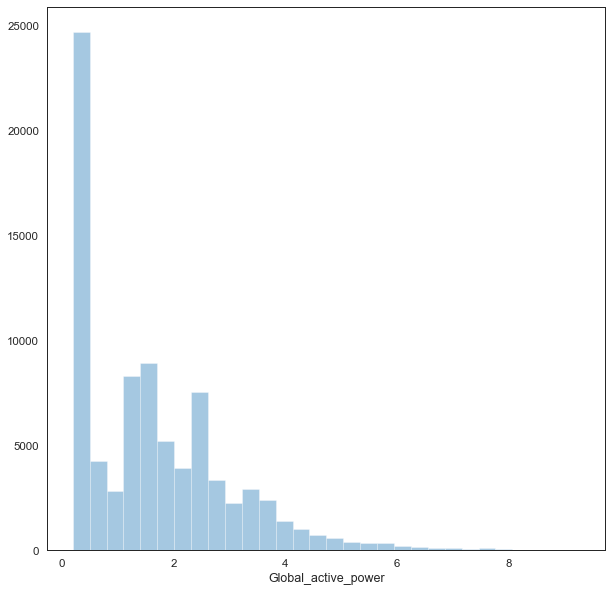

In [148]:
sns.distplot(dataset['Global_active_power'],kde=False,bins=30)

<AxesSubplot:xlabel='Global_reactive_power'>

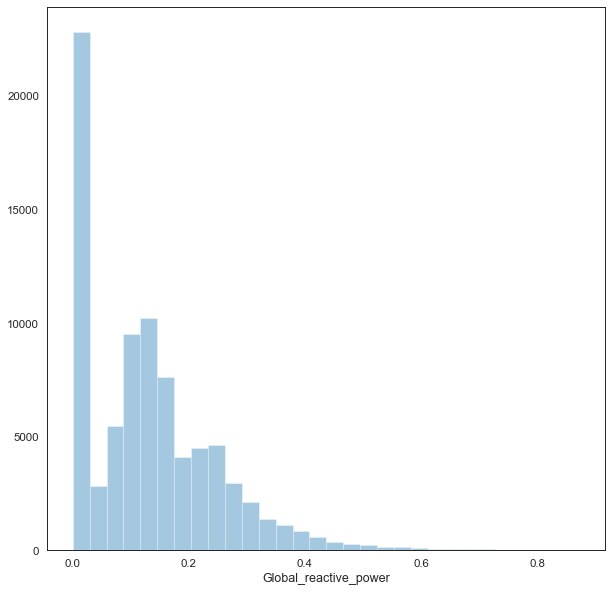

In [149]:
sns.distplot(dataset['Global_reactive_power'],kde=False,bins=30)

<AxesSubplot:xlabel='Voltage'>

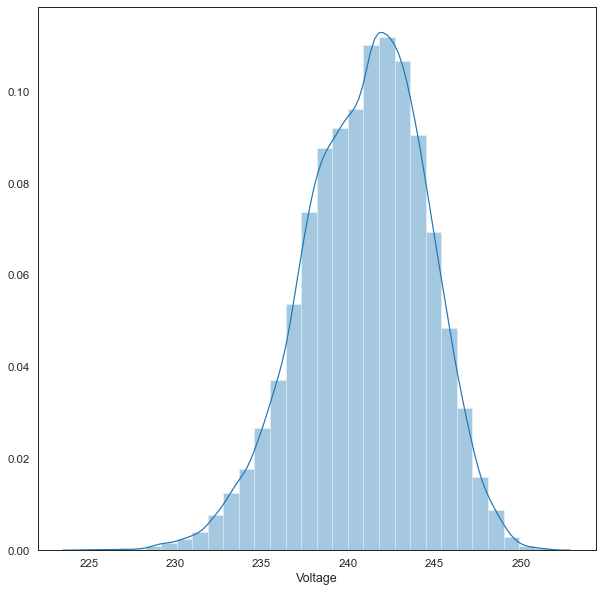

In [150]:
sns.distplot(dataset['Voltage'],kde=True,bins=30)

<AxesSubplot:xlabel='Global_intensity'>

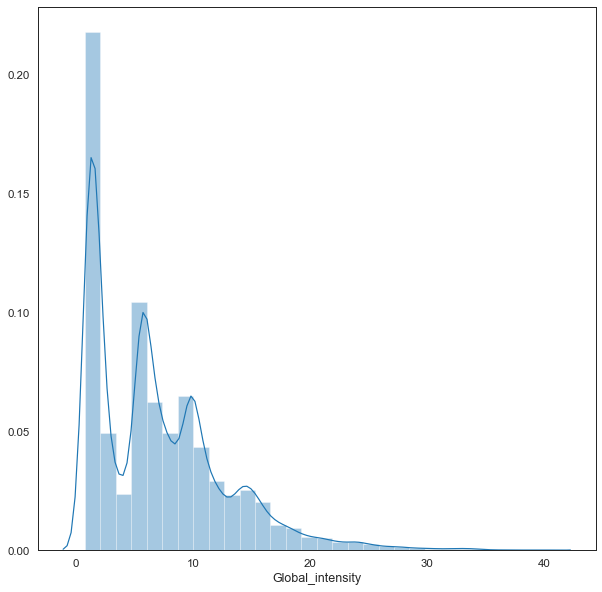

In [151]:
sns.distplot(dataset['Global_intensity'],kde=True,bins=30)

In [152]:
dataset.corr()

Global_active_power  Global_reactive_power  Voltage  \
Global_active_power                 1.0000                 0.2528  -0.6400   
Global_reactive_power               0.2528                 1.0000  -0.1643   
Voltage                            -0.6400                -0.1643   1.0000   
Global_intensity                    0.9988                 0.2645  -0.6463   
Sub_metering_1                      0.4202                 0.1105  -0.2420   
Sub_metering_2                      0.4254                 0.1743  -0.2123   
Sub_metering_3                      0.5459                 0.1030  -0.4368   
sub_metering_4                      0.7584                 0.1764  -0.4775   

                       Global_intensity  Sub_metering_1  Sub_metering_2  \
Global_active_power              0.9988          0.4202          0.4254   
Global_reactive_power            0.2645          0.1105          0.1743   
Voltage                         -0.6463         -0.2420         -0.2123   
Global_intensity                 1.0000          0.4244          0.4302   
Sub_metering_1                   0.4244          1.0000          0.0679   
Sub_metering_2                   0.4302          0.0679          1.0000   
Sub_metering_3                   0.5365          0.1219          0.1187   
sub_metering_4                   0.7578          0.0720          0.0262   

                       Sub_metering_3  sub_metering_4  
Global_active_power            0.5459          0.7584  
Global_reactive_power          0.1030          0.1764  
Voltage                       -0.4368         -0.4775  
Global_intensity               0.5365          0.7578  
Sub_metering_1                 0.1219          0.0720  
Sub_metering_2                 0.1187          0.0262  
Sub_metering_3                 1.0000          0.1192  
sub_metering_4                 0.1192          1.0000

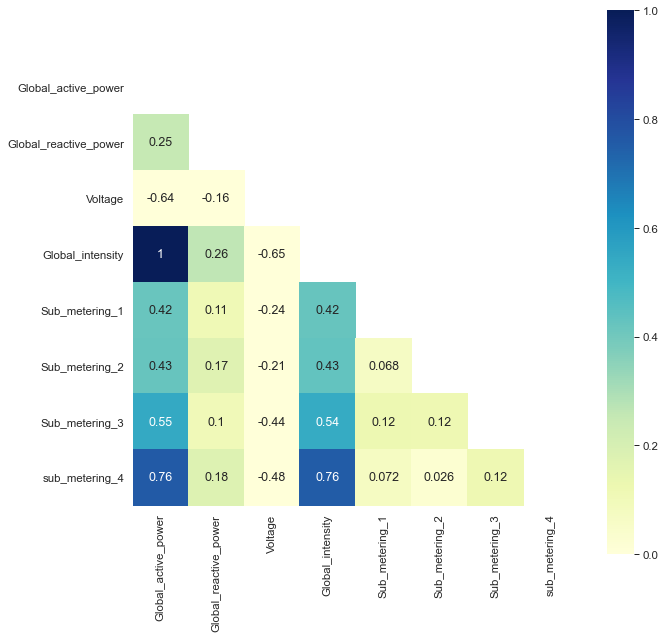

In [153]:
pearson = dataset.corr(method='pearson')
mask = np.zeros_like(pearson)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(pearson, vmax=1, vmin=0, square=True, cbar=True, annot=True, cmap="YlGnBu", mask=mask);

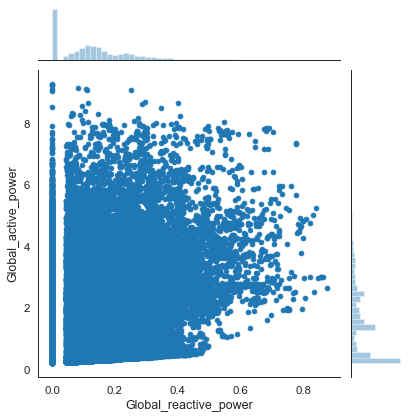

In [154]:
sns.jointplot( x = 'Global_reactive_power' , y = 'Global_active_power' , data = dataset , kind = 'scatter')

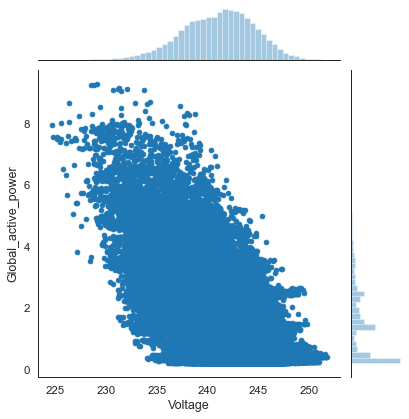

In [155]:
sns.jointplot( x = 'Voltage' , y = 'Global_active_power' , data = dataset , kind = 'scatter')

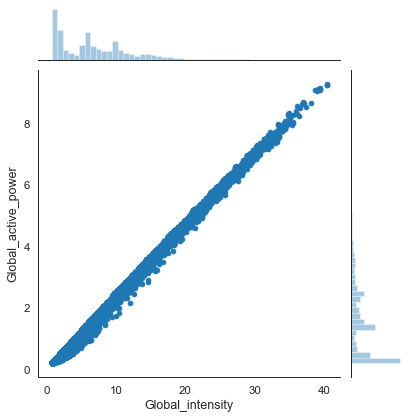

In [156]:
sns.jointplot( x = 'Global_intensity' , y = 'Global_active_power' , data = dataset , kind = 'scatter')

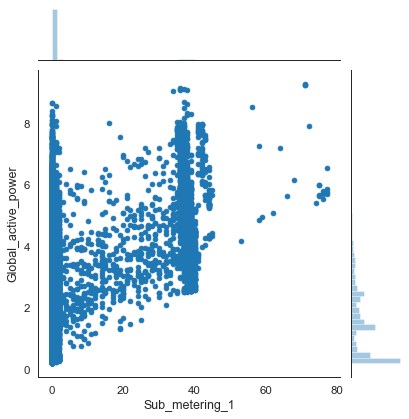

In [157]:
sns.jointplot( x = 'Sub_metering_1' , y = 'Global_active_power' , data = dataset , kind = 'scatter')

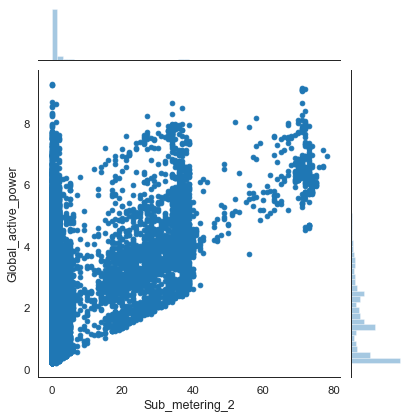

In [158]:
sns.jointplot( x = 'Sub_metering_2' , y = 'Global_active_power' , data = dataset , kind = 'scatter')

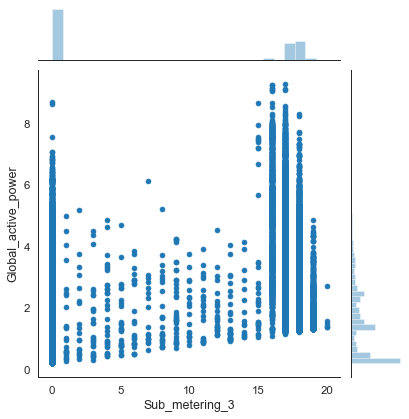

In [159]:
sns.jointplot( x = 'Sub_metering_3' , y = 'Global_active_power' , data = dataset , kind = 'scatter')

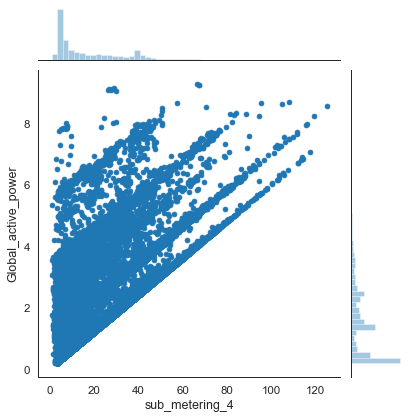

In [160]:
sns.jointplot( x = 'sub_metering_4' , y = 'Global_active_power' , data = dataset , kind = 'scatter')

In [161]:
X = dataset.iloc[:,[1,3,4,5,6]]
y = dataset.iloc[:,0]

In [162]:
print(type(X))
print(X.head())
print("\n--------------------------------------------------------------\n")
print(type(y))
print(y.head())

<class 'pandas.core.frame.DataFrame'>
                     Global_reactive_power  Global_intensity  Sub_metering_1  \
datetime                                                                       
2006-12-16 17:24:00                 0.4180           18.4000          0.0000   
2006-12-16 17:25:00                 0.4360           23.0000          0.0000   
2006-12-16 17:26:00                 0.4980           23.0000          0.0000   
2006-12-16 17:27:00                 0.5020           23.0000          0.0000   
2006-12-16 17:28:00                 0.5280           15.8000          0.0000   

                     Sub_metering_2  Sub_metering_3  
datetime                                             
2006-12-16 17:24:00          1.0000         17.0000  
2006-12-16 17:25:00          1.0000         16.0000  
2006-12-16 17:26:00          2.0000         17.0000  
2006-12-16 17:27:00          1.0000         17.0000  
2006-12-16 17:28:00          1.0000         17.0000  

----------------------

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [164]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(57395, 5)
(24599, 5)
(57395,)
(24599,)


Coefficients: 
 [-0.13207136  0.2367038  -0.00070435 -0.0004995   0.00191767]


Text(0, 0.5, 'Predicted Y')

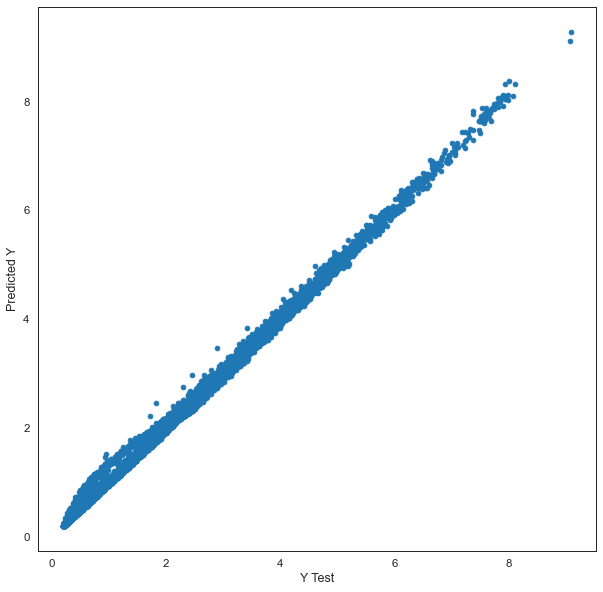

In [165]:
lm = LinearRegression()
lm.fit(X_train,y_train)
print('Coefficients: \n', lm.coef_)
predictions = lm.predict( X_test)
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

In [166]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print ('R Squares value:',metrics.r2_score(y_test, predictions))

MAE: 0.03663106641292218
MSE: 0.0036141199573739313
RMSE: 0.0601175511591576
R Squares value: 0.9979757925245915


In [167]:
best_alpha = 0.00099

regr = Lasso(alpha=best_alpha, max_iter=50000)
regr.fit(X_train,y_train)
lasso_pred = lm.predict(X_test)

In [168]:
print('MAE:', metrics.mean_absolute_error(y_test,lasso_pred))
print('MSE:', metrics.mean_squared_error(y_test,lasso_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,lasso_pred)))
print ('R Squares value:',metrics.r2_score(y_test,lasso_pred))

MAE: 0.03663106641292218
MSE: 0.0036141199573739313
RMSE: 0.0601175511591576
R Squares value: 0.9979757925245915


In [169]:
print(26*"|", "---------   END   ---------", 26*"|")

|||||||||||||||||||||||||| ---------   END   --------- ||||||||||||||||||||||||||
